# Analysis of Power Consumption of Scientific Computing Applicationsin Multicore Architectures

### Characterization, Modeling and Scheduling of Operational Power Consumption in Data centers, considering Scientific Computing Applications





> The present notebook includes and describes python scripts using the pandas and numpy libraries, for the processing and analysis of the log data generated in the experiments of characterization of power consumption in multicores To facilitate reading the notebook is divided in steps.

### Steps
* Step 1: imports and problem description
* Step 2: proccesing power ang execution logs (data proccesing)
...

# step 1: imports and problem description

Next imports are necesary for executing python code

In [61]:
from IPython.display import Image
import pandas as pd
from os import walk
%pylab inline
import re
import matplotlib.pyplot as plt
plt.rc('legend', fontsize='small')
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML
from datetime import timedelta
from __future__ import print_function, division
import statsmodels.formula.api as smf
import pylab as pl

pd.set_option('precision', 2)

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import scipy


Populating the interactive namespace from numpy and matplotlib


/home/jon/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning:

pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy



One of the activities of the thesis is collecting information of power consumption of computers (hosts) while benchmarks are executed. The goal is the characterization of power consumption regarding of computing resource type utilized and the utilization level, this is, the used percentage of the host capacity.

The following infrastructure is used: 

![alt text](milab_files/images/setup.png "Monitoring setup")


Benchmarks are executed in host while a script is polling the power meter (PDU) and logging the consumption information. There are three types of benchmarks each one oriented to a particular computational resource (CPU, memory or disk).
The benchmarks are executed individually and combined, and also with different utilization levels.

An experiment consists of one or several types of benchmarks, executing, at a certain utilization level. For example, the experiment "c1l37y5" corresponds to the CPU-bound benchmark running with a utilization level of 35.5% and the experiment "c1f1l2525" corresponds to the CPU-bound benchmark running combined with the disk-bound benchmark, both with a utilization level of 25%.

Each experiments is executed 20 times for statistical validity.

### DEFINITIONS

- Overall Power Consumption: is the power consumption measured by the power meter while a benchmark is running
- Idle Power Consumption: is the power consumption of the host without workload
- Effective PowerConsumptoin: is the Overall Power COnsumption less the Idle Power Consumption.



***

# step 2: proccesing power ang execution logs (data proccesing)

there are two data sources to process. On the one hand the power consumption (written in logging machine) and on the other the start and end of the benchmarks executions (written in host). By comparing the datetime of both sources, it is possible to know how much energy the execution of a process consumed.

#### Source 1: Power log

This information is registered polling every one second on the power meter and registering the instant power measured in a text file. 
In the following code lines the logs of each day are concatenated in the same dataframe (cleanDfEnergyLog).
The relevant fields are "datetime" and instant power "P(W)". The format of power log files is the following:

    |datetime|Timestamp (local to the python script)|I(amps)|P(W)|F(mm/dd/aaaa)|H(hh/mm/ss)|Device Load (amps)|Bank 1 Load (amps)|Bank 2 Load (amps)|P(W/VA)|Power factor|Peak Load(W)|Fecha del Peak Load|Hora del Peak Load|E(KWh)|Fecha desde que se cuenta E|Hora desde que se cuenta E|Voltaje(V)|Frecuencia(Hz)|
    |2016-08-30 00:00:00|1472526000.47|0.84|182|08/30/2016|02:54:37|0.84|0.84|0.00|182/192|0.947|1.82|02/07/2016|16:08:39|1120.5|12/16/2015|12:08:30|229.0|50.0|
    |2016-08-30 00:00:01|1472526001.65|0.85|183|08/30/2016|02:54:38|0.85|0.85|0.00|183/195|0.938|1.82|02/07/2016|16:08:39|1120.5|12/16/2015|12:08:30|229.0|50.0|



In [62]:
#Collecting power log files from disk
POW_DIR = "milab_files/energy_logs/"
list_of_file_names= next(walk(POW_DIR))[2]
dfEnergyLog = pd.DataFrame()
for file_name in list_of_file_names[:]:
    dfEnergyLogAux=pd.read_csv(POW_DIR + file_name, sep='|',dtype=np.str)
    dfEnergyLog = dfEnergyLog.append(dfEnergyLogAux)

#Cleaning (deleting rows without date format, that is: headers, broken lines)
r = re.compile('([0-9]{4}-[0-9]{2}-[0-9]{2} [0-9]{2}:[0-9]{2}:[0-9]{2})')


dfEnergyLog.datetime = dfEnergyLog.datetime.astype(str)

df=dfEnergyLog
cleanDfEnergyLog = df[df.datetime.str.match(r)][['datetime','P(W)']]
#Converting to appropriate types
cleanDfEnergyLog['datetime'] =  pd.to_datetime(cleanDfEnergyLog['datetime'][:]
                                            , format='%Y-%m-%d %H:%M:%S')
cleanDfEnergyLog['P(W)'] = pd.to_numeric(cleanDfEnergyLog['P(W)'])

#Showing result
cleanDfEnergyLog[['datetime','P(W)']].head()


,datetime,P(W)
0,2016-09-08 00:00:00,186
1,2016-09-08 00:00:01,184
2,2016-09-08 00:00:02,184
3,2016-09-08 00:00:03,184
4,2016-09-08 00:00:05,184




#### Source 2: Executions logs

When a benchmark execution begins or ends, an empty text file is created. The filename contains the info: 

- Experiment id: It resumes the benchmark used (CPU, memory o disk), the modality (single o combined) and the utilization level (12.5%, 25%, ...).
- Execution id: It is an identification for the particular run.
- Datetime: Timestamp of the file creation
- Begin or end flag: It indicates if is the begining or the end of the execution


The format of execution log filemanes is the following:

   c1f1l2525_20160912235624996_2016|09|12-23:56:25:001.ini


In the following lines of code the execution logs are collected and grouped by modality-host in dataframes. Each line of the dataframes corresponds to one benchmark execution (it indicates the start and the end)

In [63]:

#Collecting execution logs files from disk
def collectExecutionLogs(EXE_DIR):

    list_of_file_names= next(walk(EXE_DIR))[2]
    df_exe = pd.DataFrame(list_of_file_names)

    #Separating the name of the file in columns by split 
    df_exe.columns = ['data']
    df_exe = pd.DataFrame(df_exe.data.str.split('_').tolist(), columns = ['cod','run','data'])
    df_exe_aux = pd.DataFrame(df_exe.data.str.split('.').tolist(), columns = ['datetime','inifin'])
    df_exe['inifin'] = df_exe_aux['inifin']
    
    #Truncating milliseconds, they are unnecessary
    df_exe['datetime'] = df_exe_aux['datetime'].str.slice(0,-4)
     
    #Converting to appropriate types
    df_exe['datetime'] =  pd.to_datetime(df_exe['datetime'][:]
                                                 , format='%Y|%m|%d-%H:%M:%S')
    #merging and filtering to get one execution per row
    df_exe_merged = pd.merge(df_exe, df_exe, on='run')[['cod_x','run','datetime_x','inifin_x','datetime_y','inifin_y']]
    df_exe_filtered = df_exe_merged[df_exe_merged.inifin_x=='ini'][df_exe_merged.inifin_y=='end']
    return df_exe_filtered


df_exe_energy_single_intel = collectExecutionLogs("milab_files/executions/energy/single/intel");
df_exe_energy_single_amd = collectExecutionLogs("milab_files/executions/energy/single/amd");

df_exe_energy_double_intel = collectExecutionLogs("milab_files/executions/energy/double/intel");
df_exe_energy_double_amd = collectExecutionLogs("milab_files/executions/energy/double/amd");

df_exe_energy_triple_intel = collectExecutionLogs("milab_files/executions/energy/triple/intel");
df_exe_energy_triple_amd = collectExecutionLogs("milab_files/executions/energy/triple/amd");

#Showing result example
df_exe_energy_triple_amd.head()

/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,cod_x,run,datetime_x,inifin_x,datetime_y,inifin_y
1,c1m2f1l252550,20161031052009429,2016-10-31 05:20:09,ini,2016-10-31 05:21:11,end
6,c1m2f1l502525,20161031070907407,2016-10-31 07:09:07,ini,2016-10-31 07:10:09,end
10,c1m2f1l252525,20161031021209690,2016-10-31 02:12:09,ini,2016-10-31 02:13:11,end
14,c1m2f1l252550,20161031060828925,2016-10-31 06:08:28,ini,2016-10-31 06:09:45,end
18,c1m2f1l502525,20161031065100152,2016-10-31 06:51:00,ini,2016-10-31 06:52:02,end


# step 3: pre-proccesing and crossing data (data proccesing)

Over the dataframes of the benchmark execution it is neccesary to execute the following operations to facilitate the visualization and analysis:

- Transforming "experiment cod" to "benchmark cod" and "utilization level"
- Adding offset of seconds between host and logging machine
- Also, assigning variables with IDLE power consumption (this experiment is not included in this work)

In the following segments of code this operations are executed:

In [64]:
#experiment cod to benchmark code
def cod2bkcod(cod):
  if 'c1m2f1' in cod:
        return 'c1m2f1'
  if 'c1m2' in cod:
        return 'c1m2'
  if 'm2f1' in cod:
        return 'm2f1'
  if 'c1f1' in cod:
        return 'c1f1'
  if 'm2' in cod:
        return 'm2'
  if "c1" in cod:
        return 'c1'
  if "f1" in cod:
        return 'f1'

#experiment cod to utilization level. First coordinate
def cod2ULx(cod):
    
  if "252525" in cod:
        return 25
  if "252550" in cod:
        return 25
  if "255025" in cod:
        return 25
  if "502525" in cod:
        return 50  
      
    
  if "2525" in cod:
        return 25
  if "2550" in cod:
        return 25
  if "2575" in cod:
        return 25
  if "5025" in cod:
        return 50
  if "5050" in cod:
        return 50
  if "7525" in cod:
        return 75
  
  if '12y5' in cod:
        return 12.5
  if "25" in cod:
        return 25
  if "37y5" in cod:
        return 37.5
  if "50" in cod:
        return 50
  if "62y5" in cod:
        return 62.5
  if "75" in cod:
        return 75
  if "87y5" in cod:
        return 87.5
  if "100" in cod:
        return 100
      
        
#experiment cod to utilization level. Second coordinate 
def cod2ULy(cod):
  if "252525" in cod:
        return 25
  if "252550" in cod:
        return 25
  if "255025" in cod:
        return 50
  if "502525" in cod:
        return 25
    
  if "2525" in cod:
        return 25
  if "2550" in cod:
        return 50
  if "2575" in cod:
        return 75
  if "5025" in cod:
        return 25
  if "5050" in cod:
        return 50
  if "7525" in cod:
        return 25

#experiment cod to utilization level. Thrid coordinate 
def cod2ULz(cod):    
  if "252525" in cod:
        return 25
  if "252550" in cod:
        return 50
  if "255025" in cod:
        return 25
  if "502525" in cod:
        return 25
    
#experiment cod to utilization level and benchmark cod. Single modality
def singleULAndBkCod(df_exe):
    df_exe['UL'] =  df_exe.apply(lambda x:cod2ULx(x.cod_x),axis = 1) 
    df_exe['bkcod'] =  df_exe.apply(lambda x:cod2bkcod(x.cod_x),axis = 1) 
    return df_exe

#experiment cod to utilization level and benchmark cod. Double modality
def doubleULAndBkCod(df_exe):
    df_exe['ULx'] =  df_exe.apply(lambda x:cod2ULx(x.cod_x),axis = 1) 
    df_exe['ULy'] =  df_exe.apply(lambda x:cod2ULy(x.cod_x),axis = 1) 
    df_exe['bkcod'] =  df_exe.apply(lambda x:cod2bkcod(x.cod_x),axis = 1) 
    return df_exe

#experiment cod to utilization level and benchmark cod. Triple modality
def tripleULAndBkCod(df_exe):
    df_exe['ULx'] =  df_exe.apply(lambda x:cod2ULx(x.cod_x),axis = 1) 
    df_exe['ULy'] =  df_exe.apply(lambda x:cod2ULy(x.cod_x),axis = 1) 
    df_exe['ULz'] =  df_exe.apply(lambda x:cod2ULz(x.cod_x),axis = 1)     
    df_exe['bkcod'] =  df_exe.apply(lambda x:cod2bkcod(x.cod_x),axis = 1) 
    return df_exe

df_exe_energy_single_intel = singleULAndBkCod(df_exe_energy_single_intel)
df_exe_energy_single_amd = singleULAndBkCod(df_exe_energy_single_amd)

df_exe_energy_double_intel = doubleULAndBkCod(df_exe_energy_double_intel)
df_exe_energy_double_amd = doubleULAndBkCod(df_exe_energy_double_amd)

df_exe_energy_triple_intel = tripleULAndBkCod(df_exe_energy_triple_intel)
df_exe_energy_triple_amd = tripleULAndBkCod(df_exe_energy_triple_amd)

#TODO
AMD_IDLE_PC = 183.4
INTEL_IDLE_PC = 57.0


The difference in the system time between host and logging machine was registered in each experiment. In the following lines of code, begin and end times of the experiments are fixed with the corresponding offset 

In [65]:
# adding offset to begin and end time off the benchmark execution
def addOffset(df_exe,offsetSeconds):
    df_exe.datetime_y = \
    df_exe.apply(lambda x: pd.to_datetime(x.datetime_y)+pd.Timedelta(seconds=offsetSeconds) ,axis = 1)
    df_exe.datetime_x = \
    df_exe.apply(lambda x: pd.to_datetime(x.datetime_x)+pd.Timedelta(seconds=offsetSeconds) ,axis = 1)
    return df_exe
    
offsetSeconds = -10810
df_exe_energy_single_intel = addOffset(df_exe_energy_single_intel,offsetSeconds)

offsetSeconds = -11036
df_exe_energy_single_amd = addOffset(df_exe_energy_single_amd,offsetSeconds)

offsetSeconds = -180
df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1m2'] = \
addOffset(df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1m2'],offsetSeconds)

offsetSeconds = -10810
df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1f1'] = \
addOffset(df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1f1'],offsetSeconds)
df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='m2f1'] = \
addOffset(df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='m2f1'],offsetSeconds)

offsetSeconds = -11036
df_exe_energy_double_amd = \
addOffset(df_exe_energy_double_amd,offsetSeconds)

offsetSeconds = -10810
df_exe_energy_triple_intel = \
addOffset(df_exe_energy_triple_intel,offsetSeconds)

offsetSeconds = -180
df_exe_energy_triple_amd = \
addOffset(df_exe_energy_triple_amd,offsetSeconds)


/home/jon/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



After collecting data from each source, it is neccesary <strong>TO CROSS</strong> the information to get the power consumption of the benchmark executions. For each experiment, that corresponds to the combination benchmark-modality-utilization level, there are 20  independent executions. The result of the following code are dataframes grouped by modality and host. The rows are the benchmark executions and their power consumption (caculated as the average of the power registered in the logging machine whlie the benchmark is executing)  

In [66]:
#add new column "power_average" that is the average 
#of power registered between the begins and the end of an execution
def crossing(df_exe):
    power_average = []
    #power_desv = []
    for index, row in df_exe.iterrows():
      cleanDfEnergyLogCropSup = cleanDfEnergyLog[row.datetime_y > cleanDfEnergyLog.datetime]
      cleanDfEnergyLogCropInfAndSup = cleanDfEnergyLogCropSup[row.datetime_x < cleanDfEnergyLogCropSup.datetime]
      aux_mean = cleanDfEnergyLogCropInfAndSup['P(W)'].mean()      
      #aux_std = cleanDfEnergyLogCropInfAndSup['P(W)'].std() 
      if aux_mean == 0:
            print ("there is a zero")
      power_average.append(aux_mean)
      #power_desv.append(aux_std)

    df_exe['power_average'] = pd.Series(power_average).values
    return df_exe

#applying for each modality-host
df_exe_energy_single_intel=crossing(df_exe_energy_single_intel)
df_exe_energy_single_amd=crossing(df_exe_energy_single_amd)
df_exe_energy_double_intel=crossing(df_exe_energy_double_intel)
df_exe_energy_double_amd=crossing(df_exe_energy_double_amd)
df_exe_energy_triple_intel=crossing(df_exe_energy_triple_intel)
df_exe_energy_triple_amd=crossing(df_exe_energy_triple_amd)

#showing result for experiment 'c1l100' as example. the 20 independent executions
display(df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l100'])
#display(df_exe_energy_single_amd)





,cod_x,run,datetime_x,inifin_x,datetime_y,inifin_y,UL,bkcod,power_average
49,c1l100,20160831070335180,2016-08-31 03:59:39,ini,2016-08-31 04:00:41,end,100.0,c1,263.04
117,c1l100,20160831071145268,2016-08-31 04:07:49,ini,2016-08-31 04:08:51,end,100.0,c1,263.23
250,c1l100,20160831072157971,2016-08-31 04:18:01,ini,2016-08-31 04:19:04,end,100.0,c1,264.13
321,c1l100,20160831070132666,2016-08-31 03:57:36,ini,2016-08-31 03:58:39,end,100.0,c1,266.08
357,c1l100,20160831072603041,2016-08-31 04:22:07,ini,2016-08-31 04:23:09,end,100.0,c1,267.83
398,c1l100,20160831071550321,2016-08-31 04:11:54,ini,2016-08-31 04:12:56,end,100.0,c1,267.96
449,c1l100,20160831072805567,2016-08-31 04:24:09,ini,2016-08-31 04:25:12,end,100.0,c1,264.38
510,c1l100,20160831070942732,2016-08-31 04:05:46,ini,2016-08-31 04:06:49,end,100.0,c1,262.46
538,c1l100,20160831065727634,2016-08-31 03:53:31,ini,2016-08-31 03:54:34,end,100.0,c1,263.04
693,c1l100,20160831070537688,2016-08-31 04:01:41,ini,2016-08-31 04:02:44,end,100.0,c1,261.42


For complementing the power characterization, <strong>PERFORMANCE EXPERIMENTS</strong> are executed. In this experiments the same benchmarks, without time limit, are runnnig in different utilization levels. This procedure allows to determine how workload affects the performance for each type of benchmark. Only single modality is considered. 

In this case, the filename contains the info: 

- Experiment id: It resumes the benchmark used (CPU, memory o disk), the modality (single o combined) and the utilization level (12.5%, 25%, ...).
- Execution id: It is an identification of the particular run.
- Proccess id: It is an identification of one benchmark instance in the execution
- Datetime: Timestamp of the file creation
- Begin or end flag: It indicates if is the begining or the end of the execution


The format of execution log filemanes is the following:

    c1ntl12y5_20170302122631609_c1unt_20170302122631614_2017|03|02-12:26:31:620.ini

The following lines of code collect, clean, convert and merge the information of the performance execution. The result is dataframes grouped by host. The rows are the instances of the benchmark executions.  

In [67]:
#COllecting execution log files of performance experiments
def collectPerformanceExecutionLogs(EXE_DIR):

    list_of_file_names= next(walk(EXE_DIR))[2]
    df_exe = pd.DataFrame(list_of_file_names)

    #Separating the name of the file in columns by split 
    df_exe.columns = ['data']
    df_exe = pd.DataFrame(df_exe.data.str.split('_').tolist(), columns = ['cod','exe','codu','instance','data'])
    df_exe_aux = pd.DataFrame(df_exe.data.str.split('.').tolist(), columns = ['datetime','inifin'])

    #Truncating milliseconds, they are unnecessary
    df_exe['datetime'] = df_exe_aux['datetime'].str.slice(0,-4)
    df_exe['inifin'] = df_exe_aux['inifin'] 

    #Converting to appropriate types
    df_exe['datetime'] =  pd.to_datetime(df_exe['datetime'][:]
                                                 , format='%Y|%m|%d-%H:%M:%S')
    
    #Merging and filtering to get one execution per row
    df_exe_merged = pd.merge(df_exe, df_exe, on=['exe','instance','codu'])\
    [['cod_x','codu','exe','instance','datetime_x','inifin_x','cod_y','datetime_y','inifin_y']]
    df_exe_filtered = df_exe_merged[df_exe_merged.inifin_x=='ini'][df_exe_merged.inifin_y=='end']
    
    #Calcuating instances duration
    df_exe_filtered['time']=  df_exe_filtered['datetime_y'] - df_exe_filtered['datetime_x']
    df_exe_filtered['seconds']=   df_exe_filtered['time'].dt.total_seconds()
        
    return df_exe_filtered


df_exe_performance_single_amd = collectPerformanceExecutionLogs("milab_files/executions/performance/single/amd")
df_exe_performance_single_intel = collectPerformanceExecutionLogs("milab_files/executions/performance/single/intel")

#Obtaining utilization level 
df_exe_performance_single_amd = singleULAndBkCod(df_exe_performance_single_amd)
df_exe_performance_single_intel = singleULAndBkCod(df_exe_performance_single_intel)

#Showing result example
df_exe_performance_single_intel.head()


/home/jon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,cod_x,codu,exe,instance,datetime_x,inifin_x,cod_y,datetime_y,inifin_y,time,seconds,UL,bkcod
1,m2ntl100,m2unt,20170302191600598,20170302191602128,2017-03-02 19:16:02,ini,m2ntl100,2017-03-02 19:17:20,end,00:01:18,78.0,100.0,m2
6,f1ntl100,f1unt,20170304053230771,20170304053230979,2017-03-04 05:32:30,ini,f1ntl100,2017-03-04 05:35:14,end,00:02:44,164.0,100.0,f1
12,m2ntl87y5,m2unt,20170302181613817,20170302181615425,2017-03-02 18:16:15,ini,m2ntl87y5,2017-03-02 18:17:21,end,00:01:06,66.0,87.5,m2
15,m2ntl87y5,m2unt,20170302181613817,20170302181615425,2017-03-02 18:16:15,ini,m2ntl87y5,2017-03-02 18:17:21,end,00:01:06,66.0,87.5,m2
16,m2ntl87y5,m2unt,20170302181613817,20170302181615425,2017-03-02 18:16:15,ini,m2ntl87y5,2017-03-02 18:17:21,end,00:01:06,66.0,87.5,m2




# step 4: ploting data (data visualization)



The following code shows the <strong> POWER CONSUMPTION OF SINGLE EXECUTIONS</strong>, for both host. 

,UL,AMD cpu,AMD cpu EC,AMD memory,AMD memory EC,AMD disk,AMD disk EC,Intel cpu,Intel cpu EC,Intel memory,Intel memory EC,Intel disk,Intel disk EC
0,12.5,194.4,11.0,215.5,32.1,188.1,4.7,121.6,64.6,125.9,68.9,67.5,10.5
1,25.0,205.0,21.6,238.7,55.3,189.3,5.9,136.6,79.6,156.3,99.3,68.0,11.0
2,37.5,215.1,31.7,257.7,74.3,189.5,6.1,142.5,85.5,178.7,121.7,67.7,10.7
3,50.0,225.1,41.7,272.3,88.9,189.3,5.9,152.8,95.8,191.8,134.8,68.9,11.9
4,62.5,235.5,52.1,278.5,95.1,189.9,6.5,163.2,106.2,213.0,156.0,70.5,13.5
5,75.0,246.0,62.6,279.9,96.5,190.1,6.7,175.8,118.8,225.0,168.0,70.7,13.7
6,87.5,254.7,71.3,290.8,107.4,190.7,7.3,185.8,128.8,239.2,182.2,71.7,14.7
7,100.0,264.1,80.7,294.7,111.3,190.4,7.0,194.6,137.6,249.0,192.0,72.4,15.4


'Energy-simple-AMD'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Power (W)')

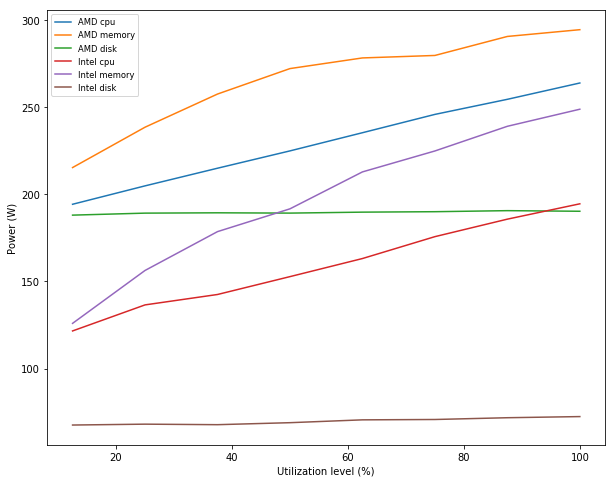

In [68]:
#bla = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='c1']
#display( bla[bla['cod_x']=='c1l25'] )

pd.set_option('precision', 1)

df_exe_energy_single_amd_c1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()

df_exe_energy_single_amd_m2_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='m2']\
         .groupby('UL').mean().reset_index()

df_exe_energy_single_amd_f1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='f1']\
         .groupby('UL').mean().reset_index()

df_exe_energy_single_intel_c1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()
    
df_exe_energy_single_intel_m2_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='m2']\
         .groupby('UL').mean().reset_index()

df_exe_energy_single_intel_f1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='f1']\
         .groupby('UL').mean().reset_index()    
   

df_result = pd.concat([
                    df_exe_energy_single_amd_c1_pw,\
                    df_exe_energy_single_amd_c1_pw['power_average']-AMD_IDLE_PC,\
                    df_exe_energy_single_amd_m2_pw['power_average'],\
                    df_exe_energy_single_amd_m2_pw['power_average']-AMD_IDLE_PC,\
                    df_exe_energy_single_amd_f1_pw['power_average'],\
                    df_exe_energy_single_amd_f1_pw['power_average']-AMD_IDLE_PC,\
                    df_exe_energy_single_intel_c1_pw['power_average'],\
                    df_exe_energy_single_intel_c1_pw['power_average']-INTEL_IDLE_PC,\
                    df_exe_energy_single_intel_m2_pw['power_average'],\
                    df_exe_energy_single_intel_m2_pw['power_average']-INTEL_IDLE_PC,\
                    df_exe_energy_single_intel_f1_pw['power_average'],\
                    df_exe_energy_single_intel_f1_pw['power_average']-INTEL_IDLE_PC\
                    ],\
                  axis=1)    

df_result.columns = ['UL', 
                     'AMD cpu',
                     'AMD cpu EC',
                     'AMD memory',
                     'AMD memory EC',
                     'AMD disk',
                     'AMD disk EC' ,
                     'Intel cpu', 
                     'Intel cpu EC', 
                     'Intel memory',
                     'Intel memory EC',
                     'Intel disk',
                     'Intel disk EC'
                    
                    ]


display (df_result,'Energy-simple-AMD')


aux = df_result.plot(x='UL', y=['AMD cpu', 'AMD memory','AMD disk', 'Intel cpu', 'Intel memory','Intel disk'],\
                     figsize=(10, 8)
                    )

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Power (W)")


The following code shows the <strong> POWER CONSUMPTION OF COMBINED EXECUTIONS </strong> (in pairs) for both host. 


,ULx,ULy,AMD cpu mem,AMD cpu mem EC,AMD cpu disk,AMD cpu disk EC,AMD mem disk,AMD mem disk EC,Intel cpu mem,Intel cpu mem EC,Intel cpu disk,Intel cpu disk EC,Intel mem disk,Intel mem disk EC
0,25,25,259.4,76.0,210.0,26.6,243.9,60.5,264.1,207.1,136.4,79.4,174.1,117.1
1,25,50,290.3,106.9,211.5,28.1,241.8,58.4,296.5,239.5,139.0,82.0,176.2,119.2
2,25,75,312.7,129.3,212.4,29.0,245.9,62.5,325.6,268.6,137.2,80.2,172.0,115.0
3,50,25,277.1,93.7,229.8,46.4,268.2,84.8,279.1,222.1,154.2,97.2,206.4,149.4
4,50,50,310.3,126.9,234.3,50.9,269.5,86.1,320.4,263.4,156.5,99.5,208.6,151.6
5,75,25,295.8,112.4,248.4,65.0,287.0,103.6,302.3,245.3,177.8,120.8,228.5,171.5


'Energy-double'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Power (W)')

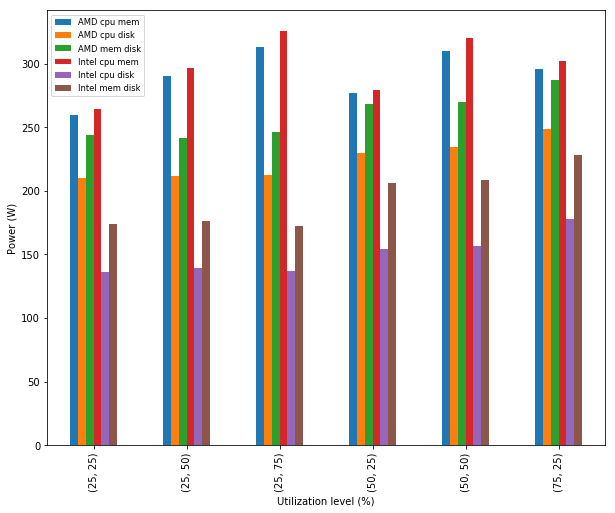

In [69]:
df_exe_energy_double_amd_pw_c1m2 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='c1m2']\
         .groupby(['ULx','ULy']).mean().reset_index()
df_exe_energy_double_amd_pw_c1f1 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='c1f1']\
         .groupby(['ULx','ULy']).mean().reset_index()
df_exe_energy_double_amd_pw_m2f1 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='m2f1']\
         .groupby(['ULx','ULy']).mean().reset_index()    

df_exe_energy_double_intel_pw_c1m2 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1m2']\
         .groupby(['ULx','ULy']).mean().reset_index()
df_exe_energy_double_intel_pw_c1f1 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1f1']\
         .groupby(['ULx','ULy']).mean().reset_index()
df_exe_energy_double_intel_pw_m2f1 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='m2f1']\
         .groupby(['ULx','ULy']).mean().reset_index()
   
df_result = pd.concat([\
                    df_exe_energy_double_amd_pw_c1m2,\
                    df_exe_energy_double_amd_pw_c1m2['power_average']-AMD_IDLE_PC,\
                    df_exe_energy_double_amd_pw_c1f1['power_average'],\
                    df_exe_energy_double_amd_pw_c1f1['power_average']-AMD_IDLE_PC,\
                    df_exe_energy_double_amd_pw_m2f1['power_average'],\
                    df_exe_energy_double_amd_pw_m2f1['power_average']-AMD_IDLE_PC,\
                    
                       
                    df_exe_energy_double_intel_pw_c1m2['power_average'],\
                    df_exe_energy_double_intel_pw_c1m2['power_average']-INTEL_IDLE_PC,\
                    df_exe_energy_double_intel_pw_c1f1['power_average'],\
                    df_exe_energy_double_intel_pw_c1f1['power_average']-INTEL_IDLE_PC,\
                                           
                    df_exe_energy_double_intel_pw_m2f1['power_average'],\
                       df_exe_energy_double_intel_pw_m2f1['power_average']-INTEL_IDLE_PC\
                   ],axis=1)    
    

df_result.columns = ['ULx', 
                     'ULy', 
                    'AMD cpu mem',
                     'AMD cpu mem EC',
                     'AMD cpu disk',
                     'AMD cpu disk EC', 
                     'AMD mem disk',
                     'AMD mem disk EC',                     
                     'Intel cpu mem',
                     'Intel cpu mem EC',                     
                     'Intel cpu disk',
                     'Intel cpu disk EC',                     
                     'Intel mem disk',
                     'Intel mem disk EC']

display (df_result,'Energy-double')
aux = df_result.plot(x= ['ULx','ULy'],y=['AMD cpu mem', 'AMD cpu disk', 'AMD mem disk',\
                  'Intel cpu mem', 'Intel cpu disk', 'Intel mem disk'],kind='bar', figsize=(10, 8))

df_double_result= df_result.copy()


aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Power (W)")


The following code shows the <strong>POWER CONSUMPTION OF COMBINED EXECUTIONS (IN THREE)</strong> for both host. 


,ULx,ULy,ULz,AMD cpu mem disk,AMD cpu mem disk EC,Intel cpu mem disk,Intel cpu mem disk EC
0,25,25,25,266.3,82.9,177.4,120.4
1,25,25,50,266.9,83.5,178.7,121.7
2,25,50,25,303.2,119.8,220.9,163.9
3,50,25,25,288.1,104.7,195.0,138.0


'Energy-CPU-Memory-Disk-triple'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Power (W)')

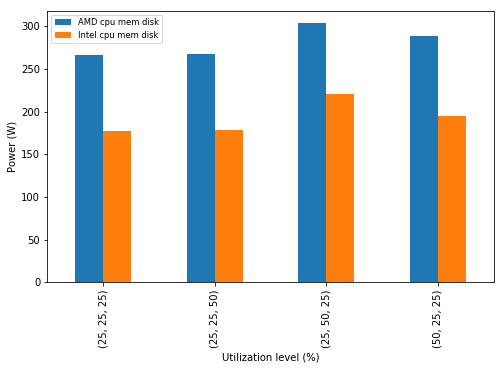

In [70]:
df_exe_energy_triple_amd_pw_c1m2f1 = df_exe_energy_triple_amd[df_exe_energy_triple_amd['bkcod']=='c1m2f1']\
.groupby(['ULx','ULy','ULz']).mean().reset_index()

df_exe_energy_triple_intel_pw_c1m2f1 = df_exe_energy_triple_intel[df_exe_energy_triple_intel['bkcod']=='c1m2f1']\
.groupby(['ULx','ULy','ULz']).mean().reset_index()

df_result = pd.concat([\
                    df_exe_energy_triple_amd_pw_c1m2f1,
                    df_exe_energy_triple_amd_pw_c1m2f1['power_average']-AMD_IDLE_PC,
                       df_exe_energy_triple_intel_pw_c1m2f1['power_average'],\
                        df_exe_energy_triple_intel_pw_c1m2f1['power_average']-INTEL_IDLE_PC\
                    ],axis=1)    

df_result.columns = ['ULx', 'ULy', 'ULz', 
                     'AMD cpu mem disk',
                     'AMD cpu mem disk EC',
                     'Intel cpu mem disk',
                     'Intel cpu mem disk EC'
                    ]
display(df_result,'Energy-CPU-Memory-Disk-triple')
aux= df_result.plot(x= ['ULx','ULy','ULz'],y=['AMD cpu mem disk', 'Intel cpu mem disk'],kind='bar', figsize=(8, 5))

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Power (W)")

The following code calculates the standar deviation of triple combined experiments

In [71]:
# COPY DATAFRAME TO DO THIS

#df_exe_energy_triple_amd_pw_c1m2f1 = df_exe_energy_triple_amd[df_exe_energy_triple_amd['bkcod']=='c1m2f1']\
#.groupby(['ULx','ULy','ULz']).std().reset_index()

#df_exe_energy_triple_intel_pw_c1m2f1 = df_exe_energy_triple_intel[df_exe_energy_triple_intel['bkcod']=='c1m2f1']\
#.groupby(['ULx','ULy','ULz']).std().reset_index()

#df_result = pd.concat([\
#                    df_exe_energy_triple_amd_pw_c1m2f1,\
#                    df_exe_energy_triple_intel_pw_c1m2f1['power_average'],\
#                    ],axis=1)    

#df_result.columns = ['ULx', 'ULy', 'ULz', 'AMD cpu mem disk', 'Intel cpu mem disk']
#display(df_result,'Energy-CPU-Memory-Disk-triple')
#aux= df_result.plot(x= ['ULx','ULy','ULz'],y=['AMD cpu mem disk', 'Intel cpu mem disk'],kind='bar', figsize=(8, 5))

#aux.set_xlabel("Utilization level (%)")
#aux.set_ylabel("Power (W)")

The following code shows results of  <strong>PERFORMANCE OF SINGLE EXECUTIONS </strong> for both host. 



,cod_x,codu,exe,instance,datetime_x,inifin_x,cod_y,datetime_y,inifin_y,time,seconds,UL,bkcod
10,f1ntl87y5,f1unt,20170207194619767,20170207194621197,2017-02-07 19:46:21,ini,f1ntl87y5,2017-02-07 20:24:19,end,00:37:58,2278.0,87.5,f1
1146,f1ntl87y5,f1unt,20170207194619767,20170207194619771,2017-02-07 19:46:19,ini,f1ntl87y5,2017-02-07 20:21:28,end,00:35:09,2109.0,87.5,f1
3110,f1ntl87y5,f1unt,20170207194619767,20170207194619872,2017-02-07 19:46:19,ini,f1ntl87y5,2017-02-07 20:24:19,end,00:38:00,2280.0,87.5,f1
3450,f1ntl87y5,f1unt,20170207194619767,20170207194621401,2017-02-07 19:46:21,ini,f1ntl87y5,2017-02-07 20:24:19,end,00:37:58,2278.0,87.5,f1
4206,f1ntl87y5,f1unt,20170207194619767,20170207194620177,2017-02-07 19:46:20,ini,f1ntl87y5,2017-02-07 20:19:37,end,00:33:17,1997.0,87.5,f1
6514,f1ntl87y5,f1unt,20170207194619767,20170207194620585,2017-02-07 19:46:20,ini,f1ntl87y5,2017-02-07 20:24:19,end,00:37:59,2279.0,87.5,f1
6609,f1ntl87y5,f1unt,20170207194619767,20170207194621808,2017-02-07 19:46:24,ini,f1ntl87y5,2017-02-07 20:20:09,end,00:33:45,2025.0,87.5,f1
7346,f1ntl87y5,f1unt,20170207194619767,20170207194620891,2017-02-07 19:46:20,ini,f1ntl87y5,2017-02-07 20:24:42,end,00:38:22,2302.0,87.5,f1
9598,f1ntl87y5,f1unt,20170207194619767,20170207194621299,2017-02-07 19:46:21,ini,f1ntl87y5,2017-02-07 20:24:19,end,00:37:58,2278.0,87.5,f1
10986,f1ntl87y5,f1unt,20170207194619767,20170207194619973,2017-02-07 19:46:19,ini,f1ntl87y5,2017-02-07 20:24:39,end,00:38:20,2300.0,87.5,f1


,UL,AMD cpu,AMD mem,AMD disk,Intel cpu,Intel mem,Intel disk
0,12.5,44.4,90.2,234.7,35.8,34.6,36.0
1,25.0,44.9,136.8,547.7,30.4,26.6,74.0
2,37.5,45.0,179.8,839.4,36.2,41.1,114.7
3,50.0,45.0,220.8,1397.8,30.8,41.8,154.5
4,62.5,45.0,259.1,1644.0,29.5,67.5,195.9
5,75.0,45.0,326.7,2006.3,29.9,62.2,239.0
6,87.5,45.0,408.2,2514.9,34.0,74.5,279.1
7,100.0,50.5,490.6,2571.5,47.4,82.5,313.6


'Performance-single'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Makespan (s)')

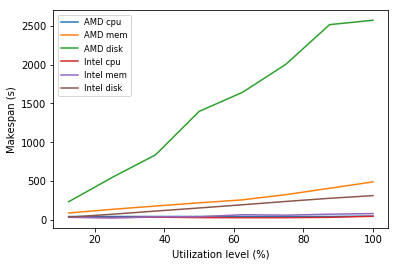

In [72]:

display(df_exe_performance_single_amd[df_exe_performance_single_amd['exe']=='20170207194619767'])

pd.set_option('precision', 1)
df_exe_performance_single_amd_pw_c1unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='c1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index()

df_exe_performance_single_amd_pw_m2unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='m2unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index()
    
df_exe_performance_single_amd_pw_f1unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='f1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index() 
    
df_exe_performance_single_intel_pw_c1unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='c1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index()

df_exe_performance_single_intel_pw_m2unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='m2unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index()
    
df_exe_performance_single_intel_pw_f1unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='f1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).mean().reset_index()
    
    
df_result = pd.concat([df_exe_performance_single_amd_pw_c1unt,\
                    df_exe_performance_single_amd_pw_m2unt['seconds'],\
                    df_exe_performance_single_amd_pw_f1unt['seconds'],\
                   df_exe_performance_single_intel_pw_c1unt['seconds'],\
                    df_exe_performance_single_intel_pw_m2unt['seconds'],\
                    df_exe_performance_single_intel_pw_f1unt['seconds']],\
                  axis=1)    


df_result.columns = ['UL', 'AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu', 'Intel mem', 'Intel disk']
display (df_result,'Performance-single')

aux=df_result.plot(x= ['UL'],y=['AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu',\
                                         'Intel mem', 'Intel disk'])

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Makespan (s)")



# step 5: efficiency study


<strong>EFFICIENCY</strong> metric is defined as $PC \times \;makespan \;/ \;3600 \;/\; number \;of\; instances$, where $PC$ is the Overall Power Consumption. The following code shows the metric for all benchmarks in both host. The more efficient level of utilization for each benchmark is highlighted.


In [73]:
pd.set_option('precision', 3)
df_result = pd.concat([df_exe_energy_single_amd_c1_pw['UL'],\
                       
                    df_exe_energy_single_amd_c1_pw['power_average']*\
                    df_exe_performance_single_amd_pw_c1unt['seconds']/\
                       (df_exe_energy_single_amd_c1_pw['UL']*3/12.5)/3600,\
                    
                       df_exe_energy_single_amd_m2_pw['power_average']*\
                    df_exe_performance_single_amd_pw_m2unt['seconds']/\
                       (df_exe_energy_single_amd_m2_pw['UL']*3/12.5)/3600,\
                       
                       df_exe_energy_single_amd_f1_pw['power_average']*\
                    df_exe_performance_single_amd_pw_f1unt['seconds']/\
                       (df_exe_energy_single_amd_f1_pw['UL']*3/12.5)/3600,\
                    
                    df_exe_energy_single_intel_c1_pw['power_average']*\
                    df_exe_performance_single_intel_pw_c1unt['seconds']/\
                       (df_exe_energy_single_intel_c1_pw['UL']*3/12.5)/3600,\
                    
                       df_exe_energy_single_intel_m2_pw['power_average']*\
                    df_exe_performance_single_intel_pw_m2unt['seconds']/\
                       (df_exe_energy_single_intel_m2_pw['UL']*3/12.5)/3600,\
                       
                       df_exe_energy_single_intel_f1_pw['power_average']*\
                    df_exe_performance_single_intel_pw_f1unt['seconds']/\
                       (df_exe_energy_single_intel_f1_pw['UL']*3/12.5)/3600,\
                    
                       
                      ],                   
                  axis=1)  

df_result.columns = ['UL', 'AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu', 'Intel mem', 'Intel disk']



def highlight_min(s):
    is_min = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_min]

df_result.style.apply(highlight_min, subset=['AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu', 'Intel mem', 'Intel disk'])


,UL,AMD cpu,AMD mem,AMD disk,Intel cpu,Intel mem,Intel disk
0,12.5,0.798,1.8,4.09,0.403,0.403,0.225
1,25,0.426,1.51,4.8,0.192,0.192,0.233
2,37.5,0.299,1.43,4.91,0.159,0.227,0.24
3,50,0.234,1.39,6.13,0.109,0.185,0.246
4,62.5,0.196,1.34,5.78,0.0892,0.266,0.256
5,75,0.171,1.41,5.89,0.081,0.216,0.261
6,87.5,0.152,1.57,6.34,0.0834,0.236,0.265
7,100,0.154,1.67,5.67,0.107,0.238,0.263


# step 6: execution mode comparision (data visualization)


The following code compares the <strong>EFFECTIVE POWER CONSUMPTION OF EXECUTIONS IN SINGLE AND DOUBLE MODE</strong>. The following figure ilustrates the concept. Different color indicates different benchmarks.

![alt text](milab_files/images/vs.png "Single vs Double execution")

The bar graphic below shows the power gain (or loss) of executions combined over executions independently. In this case the idle consumption is not considered.

,ULx,ULy,AMD cpu-mem EC,AMD cpu-disk EC,AMD mem-disk EC,INTEL cpu-mem EC,INTEL cpu-disk EC,INTEL mem-disk EC
0,25,25,0.771,0.830,0.612,-28.244,11.188,-6.697
1,25,50,3.592,-0.671,2.810,-25.207,9.398,-8.011
2,25,75,-11.303,-0.708,-0.545,-21.016,13.060,-1.996
3,50,25,3.213,1.137,10.007,-26.982,9.645,-3.660
4,50,50,3.694,-3.379,8.711,-32.841,8.186,-4.930
5,75,25,5.529,3.488,-1.193,-27.140,8.961,7.512


'Energy double VS single energy gain'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Effective Power gain (or loss) by executing in doble (W)')

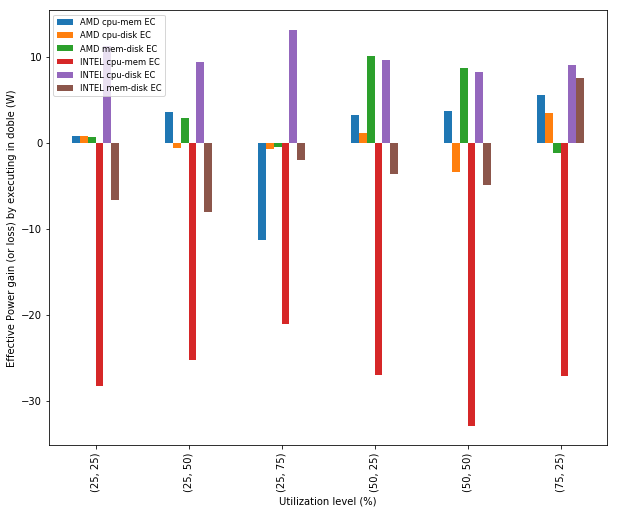

In [74]:
# CPU MEM AMD
df_left = df_exe_energy_double_amd_pw_c1m2

df_right = df_exe_energy_single_amd_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_amd_m2_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'AMD cpu + mem PC', 'AMD cpu PC','AMD mem PC']

df_result_AMD_CPUMEM = pd.concat([\
                    df_result,\
                    (df_result['AMD cpu + mem PC'] - AMD_IDLE_PC-\
                    (df_result['AMD cpu PC'] + df_result['AMD mem PC'] - AMD_IDLE_PC - AMD_IDLE_PC))*-1,\
                    ],axis=1)

df_result_AMD_CPUMEM.columns = ['ULx','ULy', 'AMD cpu + mem PC', 'AMD cpu PC','AMD mem PC',\
                     'AMD cpu-mem EC']
df_result_AMD_CPUMEM = df_result_AMD_CPUMEM[['ULx','ULy',  'AMD cpu-mem EC']]

# CPU DISK AMD
df_left = df_exe_energy_double_amd_pw_c1f1

df_right = df_exe_energy_single_amd_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_amd_f1_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'AMD cpu + disk PC', 'AMD cpu PC','AMD disk PC']

df_result_AMD_CPUDISK = pd.concat([\
                    df_result,\
                    (df_result['AMD cpu + disk PC'] - AMD_IDLE_PC-\
                    (df_result['AMD cpu PC'] + df_result['AMD disk PC'] - AMD_IDLE_PC - AMD_IDLE_PC))*-1,\
                    ],axis=1)

df_result_AMD_CPUDISK.columns = ['ULx','ULy', 'AMD cpu + disk PC', 'AMD cpu PC','AMD disk PC',\
                     'AMD cpu-disk EC']
df_result_AMD_CPUDISK = df_result_AMD_CPUDISK[['ULx','ULy',  'AMD cpu-disk EC']]


# MEM DISK AMD
df_left = df_exe_energy_double_amd_pw_m2f1

df_right = df_exe_energy_single_amd_m2_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_amd_f1_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'AMD mem + disk PC', 'AMD mem PC','AMD disk PC']

df_result_AMD_MEMDISK = pd.concat([\
                    df_result,\
                    (df_result['AMD mem + disk PC'] - AMD_IDLE_PC-\
                    (df_result['AMD mem PC'] + df_result['AMD disk PC'] - AMD_IDLE_PC - AMD_IDLE_PC))*-1,\
                    ],axis=1)

df_result_AMD_MEMDISK.columns = ['ULx','ULy', 'AMD mem + disk PC', 'AMD mem PC','AMD disk PC',\
                     'AMD mem-disk EC']
df_result_AMD_MEMDISK = df_result_AMD_MEMDISK[['ULx','ULy', 'AMD mem-disk EC']]


# CPU MEM INTEL
df_left = df_exe_energy_double_intel_pw_c1m2

df_right = df_exe_energy_single_intel_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_intel_m2_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'INTEL cpu + mem PC', 'INTEL cpu PC','INTEL mem PC']

df_result_INTEL_CPUMEM = pd.concat([\
                    df_result,\
                    (df_result['INTEL cpu + mem PC'] - INTEL_IDLE_PC-\
                    (df_result['INTEL cpu PC'] + df_result['INTEL mem PC'] - INTEL_IDLE_PC - INTEL_IDLE_PC))*-1,\
                    ],axis=1)

df_result_INTEL_CPUMEM.columns = ['ULx','ULy', 'INTEL cpu + mem PC', 'INTEL cpu PC','INTEL mem PC',\
                     'INTEL cpu-mem EC']
df_result_INTEL_CPUMEM = df_result_INTEL_CPUMEM[['ULx','ULy',  'INTEL cpu-mem EC']]

# CPU DISK INTEL
df_left = df_exe_energy_double_intel_pw_c1f1

df_right = df_exe_energy_single_intel_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_intel_f1_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'INTEL cpu + disk PC', 'INTEL cpu PC','INTEL disk PC']

df_result_INTEL_CPUDISK = pd.concat([\
                    df_result,\
                    (df_result['INTEL cpu + disk PC'] - INTEL_IDLE_PC-\
                    (df_result['INTEL cpu PC'] + df_result['INTEL disk PC'] - INTEL_IDLE_PC - INTEL_IDLE_PC))*-1,\
                    ],axis=1)

df_result_INTEL_CPUDISK.columns = ['ULx','ULy', 'INTEL cpu + disk PC', 'INTEL cpu PC','INTEL disk PC',\
                     'INTEL cpu-disk EC']
df_result_INTEL_CPUDISK = df_result_INTEL_CPUDISK[['ULx','ULy',  'INTEL cpu-disk EC']]


# MEM DISK INTEL
df_left = df_exe_energy_double_intel_pw_m2f1

df_right = df_exe_energy_single_intel_m2_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_right = df_exe_energy_single_intel_f1_pw    

df_result = pd.merge(df_result, df_right, how='left', left_on=['ULy'],right_on= ['UL'])
df_result = df_result[['ULx','ULy', 'power_average_x', 'power_average_y', 'power_average']]
df_result.columns = ['ULx','ULy', 'INTEL mem + disk PC', 'INTEL mem PC','INTEL disk PC']

df_result_INTEL_MEMDISK = pd.concat([\
                    df_result,\
                    (df_result['INTEL mem + disk PC'] - INTEL_IDLE_PC-\
                    (df_result['INTEL mem PC'] + df_result['INTEL disk PC'] - INTEL_IDLE_PC - INTEL_IDLE_PC))*-1,\
                    ],axis=1)

df_result_INTEL_MEMDISK.columns = ['ULx','ULy', 'INTEL mem + disk PC', 'INTEL mem PC','INTEL disk PC',\
                     'INTEL mem-disk EC']
df_result_INTEL_MEMDISK = df_result_INTEL_MEMDISK[['ULx','ULy', 'INTEL mem-disk EC']]





#print all together
df_result = pd.concat([\
                    df_result_AMD_CPUMEM,\
                    df_result_AMD_CPUDISK['AMD cpu-disk EC'],\
                    df_result_AMD_MEMDISK['AMD mem-disk EC'],\
                    df_result_INTEL_CPUMEM['INTEL cpu-mem EC'],\
                    df_result_INTEL_CPUDISK['INTEL cpu-disk EC'],\
                    df_result_INTEL_MEMDISK['INTEL mem-disk EC'],\
                   
                    ],axis=1) 


display(df_result,'Energy double VS single energy gain')
aux= df_result.plot(x= ['ULx','ULy'],y=['AMD cpu-mem EC',\
                                   'AMD cpu-disk EC',\
                                  'AMD mem-disk EC',\
                                   'INTEL cpu-mem EC',\
                                   'INTEL cpu-disk EC',\
                                  'INTEL mem-disk EC',\
                                  
                                  ],kind='bar',figsize=(10, 8))

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Effective Power gain (or loss) by executing in doble (W)")


The following code <strong>COMPARES EFFECTIVE POWER CONSUMPTION OF EXECUTION IN SINGLE AND TRIPLE MODE</strong>.

,ULx,ULy,ULz,AMD cpu + mem + disk PC,AMD cpu PC,AMD mem PC,AMD disk PC,AMD cpu + mem + disk EC,INTEL cpu + mem + disk PC,INTEL cpu PC,INTEL mem PC,INTEL disk PC,INTEL cpu + mem + disk EC
0,25,25,25,266.316,204.952,238.664,189.285,-0.215,177.372,136.552,156.342,68.018,69.540
1,25,25,50,266.928,204.952,238.664,189.300,-0.812,178.715,136.552,156.342,68.864,69.043
2,25,50,25,303.234,204.952,272.349,189.285,-3.448,220.861,136.552,191.757,68.018,61.466
3,50,25,25,288.104,225.050,238.664,189.285,-1.904,194.992,152.800,156.342,68.018,68.168


'Energy double VS single energy gain'

/home/jon/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Text(0,0.5,'Effective Power gain (or loss) by executing in triple (W)')

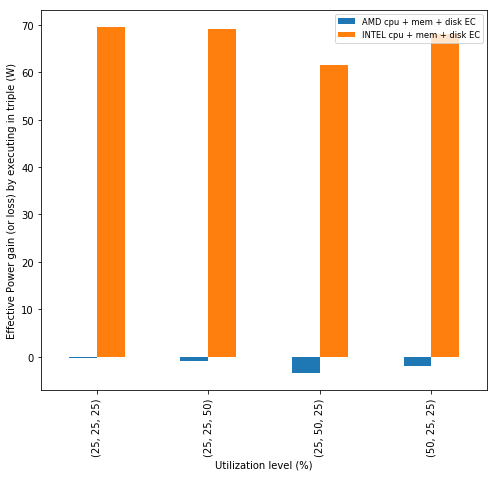

In [75]:
#AMD
df_left = df_exe_energy_triple_amd_pw_c1m2f1

df_right = df_exe_energy_single_amd_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_left = df_result
df_right = df_exe_energy_single_amd_m2_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULy'],right_on= ['UL'])

df_left = df_result
df_right = df_exe_energy_single_amd_f1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULz'],right_on= ['UL'])

df_result.columns = ['ULx','ULy','ULz', 'AMD cpu + mem + disk PC','foo1', 'AMD cpu PC','foo2',\
                     'AMD mem PC','foo3','AMD disk PC']

df_result = df_result[['ULx','ULy','ULz', 'AMD cpu + mem + disk PC', 'AMD cpu PC',\
                     'AMD mem PC','AMD disk PC']]

df_result_AMD_CPUMEMDISK = pd.concat([\
                    df_result,\
                    (df_result['AMD cpu + mem + disk PC'] - AMD_IDLE_PC-\
                    (df_result['AMD cpu PC'] + df_result['AMD mem PC'] + df_result['AMD disk PC'] \
                     - AMD_IDLE_PC * 3))*-1,\
                    ],axis=1)

df_result_AMD_CPUMEMDISK.columns = ['ULx','ULy','ULz', 'AMD cpu + mem + disk PC', 'AMD cpu PC',\
                     'AMD mem PC','AMD disk PC','AMD cpu + mem + disk EC']

#INTEL
df_left = df_exe_energy_triple_intel_pw_c1m2f1

df_right = df_exe_energy_single_intel_c1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULx'],right_on= ['UL'])

df_left = df_result
df_right = df_exe_energy_single_intel_m2_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULy'],right_on= ['UL'])

df_left = df_result
df_right = df_exe_energy_single_intel_f1_pw    
df_result = pd.merge(df_left, df_right, how='left', left_on=['ULz'],right_on= ['UL'])

df_result.columns = ['ULx','ULy','ULz', 'INTEL cpu + mem + disk PC','foo1', 'INTEL cpu PC','foo2',\
                     'INTEL mem PC','foo3','INTEL disk PC']

df_result = df_result[['ULx','ULy','ULz', 'INTEL cpu + mem + disk PC', 'INTEL cpu PC',\
                     'INTEL mem PC','INTEL disk PC']]

df_result_INTEL_CPUMEMDISK = pd.concat([\
                    df_result,\
                    (df_result['INTEL cpu + mem + disk PC'] - INTEL_IDLE_PC-\
                    (df_result['INTEL cpu PC'] + df_result['INTEL mem PC'] + df_result['INTEL disk PC'] \
                     - INTEL_IDLE_PC * 3))*-1,\
                    ],axis=1)

df_result_INTEL_CPUMEMDISK.columns = ['ULx','ULy','ULz', 'INTEL cpu + mem + disk PC', 'INTEL cpu PC',\
                     'INTEL mem PC','INTEL disk PC','INTEL cpu + mem + disk EC']

#print all together
df_result = pd.concat([\
                    df_result_AMD_CPUMEMDISK,\
                    df_result_INTEL_CPUMEMDISK\
                       [['INTEL cpu + mem + disk PC', 'INTEL cpu PC',\
                     'INTEL mem PC','INTEL disk PC','INTEL cpu + mem + disk EC']]\
                    ],axis=1) 

display(df_result,'Energy double VS single energy gain')

aux=df_result.plot(x= ['ULx','ULy','ULz'],y=['AMD cpu + mem + disk EC',\
                                'INTEL cpu + mem + disk EC',
                                  ],kind='bar',figsize=(8, 7))

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Effective Power gain (or loss) by executing in triple (W)")



# step 7: energy modeling. single execution mode.  (data modeling)


In this section the previous data is utilized to find dependencies between the variables of the problem:

- utilization level 
- power consumption
- resources bound
- host architecture


The first and simplest model <strong>considers only the dependency between utilization level and power consumption</strong>. In this model all the workload is considered CPU-bound. The following ecuation shows the relation, where $\alpha$ is the utilization level and $e$ is the power consumption predicted. 

\begin{equation} 
f(\alpha) \to e,\;
\alpha \in [0,100] \wedge e \in \rm I\!R
\end{equation}

The experimental data considered to this model is the CPU-bound benchmark execution on AMD an Intel host.

In [76]:
df_exe_energy_single_amd_c1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()

df_exe_energy_single_intel_c1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()
       
display(pd.concat([df_exe_energy_single_amd_c1_pw,df_exe_energy_single_intel_c1_pw],axis=1))    


,UL,power_average,UL,power_average
0,12.5,194.379,12.5,121.587
1,25.0,204.952,25.0,136.552
2,37.5,215.094,37.5,142.532
3,50.0,225.050,50.0,152.800
4,62.5,235.494,62.5,163.191
5,75.0,246.022,75.0,175.770
6,87.5,254.690,87.5,185.827
7,100.0,264.068,100.0,194.640


Model 1 can be resolved by <strong>LINEAR REGRESION</strong>. The following code resolves the problem and shows the parameters found. The model can be adjunted....


Text(0.5,1,'Intel linear model')

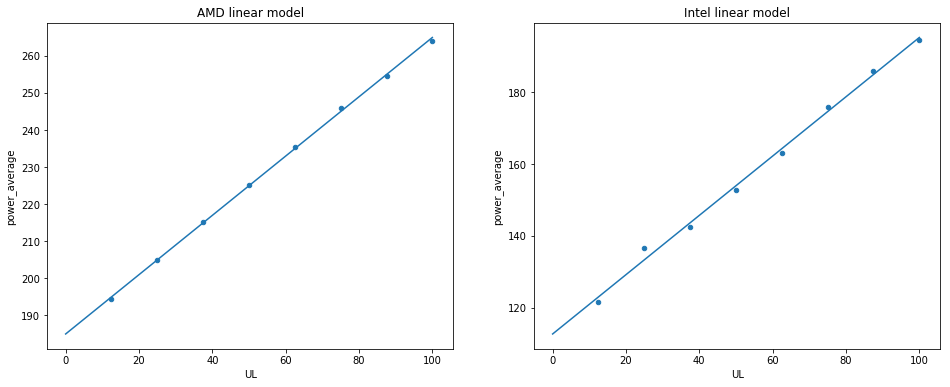

In [77]:
# create linear model 
linear_model_amd = smf.ols(formula='power_average ~ UL', data=df_exe_energy_single_amd_c1_pw).fit()
linear_model_intel = smf.ols(formula='power_average ~ UL', data=df_exe_energy_single_intel_c1_pw).fit()

# predicting
X_theoretical = pd.DataFrame({'UL': [0, 100]})
predict_amd = linear_model_amd.predict(X_theoretical)
predict_intel = linear_model_intel.predict(X_theoretical)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16, 6))
ax1.plot(X_theoretical, predict_amd)
df_exe_energy_single_amd_c1_pw.plot(kind='scatter', x='UL', y='power_average', ax=ax1)
ax1.set_title('AMD linear model')
ax2.plot(X_theoretical, predict_intel)
df_exe_energy_single_intel_c1_pw.plot(kind='scatter', x='UL', y='power_average', ax=ax2)
ax2.set_title('Intel linear model')


OLS library provides statistics test for models evaluation. Code below prints params and summary of the models.

In [78]:
print ('************************   AMD energy model - params ******************************************')
print (linear_model_amd.params)
print (' ')
print ('************************   Intel energy model - params ****************************************')
print (linear_model_intel.params)
print (' ')
print ('************************   AMD energy model - summary *****************************************')
print (linear_model_amd.summary())
print (' ')
print ('************************   Intel energy model - summary **************************************')
print (linear_model_intel.summary())
print (' ')

************************   AMD energy model - params ******************************************
Intercept    184.982
UL             0.800
dtype: float64
 
************************   Intel energy model - params ****************************************
Intercept    112.621
UL             0.827
dtype: float64
 
************************   AMD energy model - summary *****************************************
                            OLS Regression Results                            
Dep. Variable:          power_average   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     9523.
Date:                Tue, 21 Aug 2018   Prob (F-statistic):           7.80e-11
Time:                        20:13:42   Log-Likelihood:                -6.9237
No. Observations:                   8   AIC:                             17.85
Df Residuals:                       6   B

/home/jon/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



The second model considers the dependency between <strong> type of computational resource, utilization level and power consumption</strong>. However, the intelationship in the combined execution is not considered. The following ecuation shows the relation, where $\alpha$ is the utilization level of CPU, $\beta$ is the utilization level of memory, $\gamma$ is the utilization level of disk and $e$ is the power consumption predicted. 

\begin{equation} 
f(\alpha,\beta,\gamma) \to e,\;
\alpha \in [0,100] \wedge e \in \rm I\!R
\end{equation}

The experimental data considered to this model is the single CPU-bound, Memory-bound and Disk-bound benchmark executions,  on AMD an Intel host.

The following code prepares the data for modeling



In [79]:
df_exe_energy_single_amd_c1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()
df_exe_energy_single_intel_c1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='c1']\
         .groupby(['UL']).mean().reset_index()
df_exe_energy_single_amd_m2_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='m2']\
         .groupby(['UL']).mean().reset_index()
df_exe_energy_single_intel_m2_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='m2']\
         .groupby(['UL']).mean().reset_index()
df_exe_energy_single_amd_f1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='f1']\
         .groupby(['UL']).mean().reset_index()
df_exe_energy_single_intel_f1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='f1']\
         .groupby(['UL']).mean().reset_index()
df_exe_energy_single_amd_pw =   pd.concat(\
    [df_exe_energy_single_amd_c1_pw,\
     df_exe_energy_single_amd_m2_pw,\
     df_exe_energy_single_amd_f1_pw]\
    ,axis=1)  
df_exe_energy_single_amd_pw.columns = ['ul_cpu','power_cpu','ul_mem', 'power_mem','ul_disk','power_disk']
df_exe_energy_single_intel_pw =   pd.concat(\
    [df_exe_energy_single_intel_c1_pw,\
     df_exe_energy_single_intel_m2_pw,\
     df_exe_energy_single_intel_f1_pw]\
    ,axis=1)  
df_exe_energy_single_intel_pw.columns = ['ul_cpu','power_cpu','ul_mem', 'power_mem','ul_disk','power_disk']

# IDLE substraction
df_exe_energy_single_amd_pw.power_cpu = df_exe_energy_single_amd_pw.power_cpu - AMD_IDLE_PC
df_exe_energy_single_amd_pw.power_mem = df_exe_energy_single_amd_pw.power_mem - AMD_IDLE_PC
df_exe_energy_single_amd_pw.power_disk = df_exe_energy_single_amd_pw.power_disk - AMD_IDLE_PC
    
df_exe_energy_single_amd_pw['power'] = df_exe_energy_single_amd_pw.power_cpu+\
df_exe_energy_single_amd_pw.power_mem+\
df_exe_energy_single_amd_pw.power_disk

df_exe_energy_single_intel_pw.power_cpu = df_exe_energy_single_intel_pw.power_cpu - INTEL_IDLE_PC
df_exe_energy_single_intel_pw.power_mem = df_exe_energy_single_intel_pw.power_mem - INTEL_IDLE_PC
df_exe_energy_single_intel_pw.power_disk = df_exe_energy_single_intel_pw.power_disk - INTEL_IDLE_PC
    
df_exe_energy_single_intel_pw['power'] = df_exe_energy_single_intel_pw.power_cpu+\
df_exe_energy_single_intel_pw.power_mem+\
df_exe_energy_single_intel_pw.power_disk


#display(df_exe_energy_single_amd_pw) 
   

We consider three  <strong>linear models</strong> independenly

In [80]:
# create linear models for type and host
linear_model_amd_cpu = smf.ols(formula='power_cpu ~ ul_cpu', \
                           data=df_exe_energy_single_amd_pw).fit()

linear_model_amd_mem = smf.ols(formula='power_mem ~ ul_mem', \
                           data=df_exe_energy_single_amd_pw).fit()

linear_model_amd_disk = smf.ols(formula='power_disk ~ ul_disk', \
                           data=df_exe_energy_single_amd_pw).fit()

linear_model_intel_cpu = smf.ols(formula='power_cpu ~ ul_cpu', \
                           data=df_exe_energy_single_intel_pw).fit()

linear_model_intel_mem = smf.ols(formula='power_mem ~ ul_mem', \
                           data=df_exe_energy_single_intel_pw).fit()

linear_model_intel_disk = smf.ols(formula='power_disk ~ ul_disk', \
                           data=df_exe_energy_single_intel_pw).fit()


Text(0,0.5,'Power Consumption (W)')

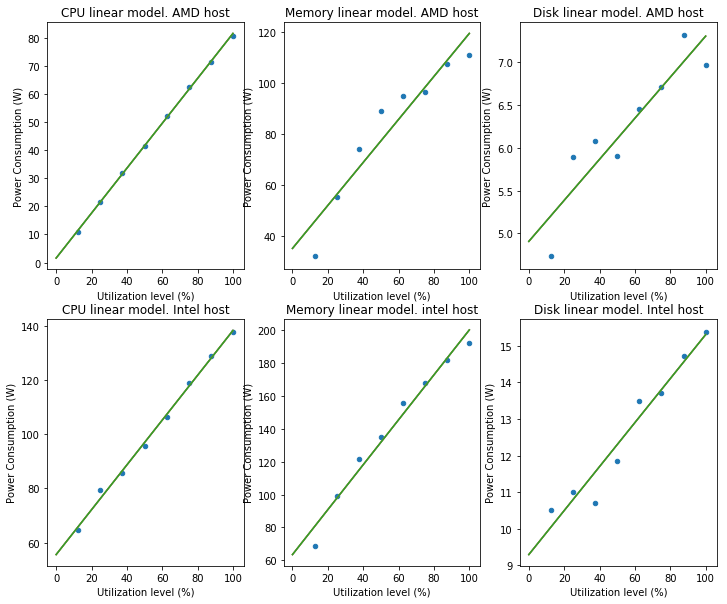

In [81]:
X_theoretical = pd.DataFrame({'ul_cpu': [0, 100],'ul_mem': [0, 100],'ul_disk': [0, 100]})


# predicting values in [0,100]
predict_amd_cpu = linear_model_amd_cpu.predict(X_theoretical)
predict_amd_mem = linear_model_amd_mem.predict(X_theoretical)
predict_amd_disk = linear_model_amd_disk.predict(X_theoretical)

predict_intel_cpu = linear_model_intel_cpu.predict(X_theoretical)
predict_intel_mem = linear_model_intel_mem.predict(X_theoretical)
predict_intel_disk = linear_model_intel_disk.predict(X_theoretical)

# plotting
f, ((ax1, ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2, 3, sharey=False, figsize=(12, 10))
ax1.plot(X_theoretical, predict_amd_cpu)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax1)
ax1.set_title('CPU linear model. AMD host')
ax2.plot(X_theoretical, predict_amd_mem)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax2)
ax2.set_title('Memory linear model. AMD host')
ax3.plot(X_theoretical, predict_amd_disk)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax3)
ax3.set_title('Disk linear model. AMD host')
ax1.set_xlabel("Utilization level (%)")
ax1.set_ylabel("Power Consumption (W)")
ax2.set_xlabel("Utilization level (%)")
ax2.set_ylabel("Power Consumption (W)")
ax3.set_xlabel("Utilization level (%)")
ax3.set_ylabel("Power Consumption (W)")
ax4.plot(X_theoretical, predict_intel_cpu)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax4)
ax4.set_title('CPU linear model. Intel host')
ax5.plot(X_theoretical, predict_intel_mem)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax5)
ax5.set_title('Memory linear model. intel host')
ax6.plot(X_theoretical, predict_intel_disk)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax6)
ax6.set_title('Disk linear model. Intel host')
ax4.set_xlabel("Utilization level (%)")
ax4.set_ylabel("Power Consumption (W)")
ax5.set_xlabel("Utilization level (%)")
ax5.set_ylabel("Power Consumption (W)")
ax6.set_xlabel("Utilization level (%)")
ax6.set_ylabel("Power Consumption (W)")



printing params and summary of linear energy models

In [82]:
print ('******************* AMD linear energy model - CPU bound workload - params *******************')
display (linear_model_amd_cpu.params)
print (' ')
print ('******************* AMD linear energy model - memory bound workload - params ****************')
display (linear_model_amd_mem.params)
print (' ')
print ('******************* AMD linear energy model - disk bound workload - params ******************')
display (linear_model_amd_disk.params)
print (' ')
print ('******************* Intel linear energy model - CPU bound workload - params ******************')
display (linear_model_intel_cpu.params)
print (' ')
print ('******************* Intel linear energy model - memory bound workload - params ***************')
display (linear_model_intel_mem.params)
print (' ')
print ('******************* Intel linear energy model - disk bound workload - params *****************')
display (linear_model_intel_disk.params)
print (' ')

print ('******************* AMD linear energy model - CPU bound workload - summary *******************')
display (linear_model_amd_cpu.summary())
print (' ')
print ('******************* AMD linear energy model - memory bound workload - summary ****************')
display (linear_model_amd_mem.summary())
print (' ')
print ('******************* AMD linear energy model - disk bound workload - summary ******************')
display (linear_model_amd_disk.summary())
print (' ')
print ('******************* Intel linear energy model - CPU bound workload - summaryd ******************')
display (linear_model_intel_cpu.summary())
print (' ')
print ('******************* Intel linear energy model - memory bound workload - summary ***************')
display (linear_model_intel_mem.summary())
print (' ')
print ('******************* Intel linear energy model - disk bound workload - summary *****************')
display (linear_model_intel_disk.summary())
print (' ')



******************* AMD linear energy model - CPU bound workload - params *******************


Intercept    1.582
ul_cpu       0.800
dtype: float64

 
******************* AMD linear energy model - memory bound workload - params ****************


Intercept    35.038
ul_mem        0.846
dtype: float64

 
******************* AMD linear energy model - disk bound workload - params ******************


Intercept    4.907
ul_disk      0.024
dtype: float64

 
******************* Intel linear energy model - CPU bound workload - params ******************


Intercept    55.621
ul_cpu        0.827
dtype: float64

 
******************* Intel linear energy model - memory bound workload - params ***************


Intercept    63.433
ul_mem        1.368
dtype: float64

 
******************* Intel linear energy model - disk bound workload - params *****************


Intercept    9.297
ul_disk      0.060
dtype: float64

 
******************* AMD linear energy model - CPU bound workload - summary *******************


/home/jon/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1334: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=8



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              power_cpu   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     9523.
Date:                Tue, 21 Aug 2018   Prob (F-statistic):           7.80e-11
Time:                        20:13:44   Log-Likelihood:                -6.9237
No. Observations:                   8   AIC:                             17.85
Df Residuals:                       6   BIC:                             18.01
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.5822      0.517      3.059      0.022       0.316       2.848
ul_cpu         0.7998      0.008     97.588      0.000       0.780       0.820
==============================================================================
Omnibus:                        0.257   Durbin-Watson:                   1.129
Prob(Omnibus):                  0.879   Jarque-Bera (JB):                0.211
Skew:                           0.258   Prob(JB):                        0.900
Kurtosis:                       2.394   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 
******************* AMD linear energy model - memory bound workload - summary ****************


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              power_mem   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.887
Method:                 Least Squares   F-statistic:                     55.94
Date:                Tue, 21 Aug 2018   Prob (F-statistic):           0.000295
Time:                        20:13:44   Log-Likelihood:                -27.920
No. Observations:                   8   AIC:                             59.84
Df Residuals:                       6   BIC:                             60.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.0378      7.138      4.909      0.003      17.573      52.503
ul_mem         0.8457      0.113      7.479      0.000       0.569       1.122
==============================================================================
Omnibus:                        0.258   Durbin-Watson:                   0.787
Prob(Omnibus):                  0.879   Jarque-Bera (JB):                0.391
Skew:                          -0.174   Prob(JB):                        0.822
Kurtosis:                       1.974   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 
******************* AMD linear energy model - disk bound workload - summary ******************


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             power_disk   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     32.62
Date:                Tue, 21 Aug 2018   Prob (F-statistic):            0.00125
Time:                        20:13:44   Log-Likelihood:                -1.5528
No. Observations:                   8   AIC:                             7.106
Df Residuals:                       6   BIC:                             7.265
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.9071      0.264     18.563      0.000       4.260       5.554
ul_disk        0.0239      0.004      5.712      0.001       0.014       0.034
==============================================================================
Omnibus:                        1.267   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.531   Jarque-Bera (JB):                0.677
Skew:                          -0.235   Prob(JB):                        0.713
Kurtosis:                       1.654   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 
******************* Intel linear energy model - CPU bound workload - summaryd ******************


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              power_cpu   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                     1435.
Date:                Tue, 21 Aug 2018   Prob (F-statistic):           2.26e-08
Time:                        20:13:44   Log-Likelihood:                -14.758
No. Observations:                   8   AIC:                             33.52
Df Residuals:                       6   BIC:                             33.67
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     55.6207      1.377     40.383      0.000      52.250      58.991
ul_cpu         0.8265      0.022     37.879      0.000       0.773       0.880
==============================================================================
Omnibus:                        3.773   Durbin-Watson:                   2.552
Prob(Omnibus):                  0.152   Jarque-Bera (JB):                1.497
Skew:                           1.057   Prob(JB):                        0.473
Kurtosis:                       2.839   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 
******************* Intel linear energy model - memory bound workload - summary ***************


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              power_mem   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     233.0
Date:                Tue, 21 Aug 2018   Prob (F-statistic):           4.99e-06
Time:                        20:13:44   Log-Likelihood:                -26.057
No. Observations:                   8   AIC:                             56.11
Df Residuals:                       6   BIC:                             56.27
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     63.4330      5.655     11.218      0.000      49.596      77.270
ul_mem         1.3676      0.090     15.266      0.000       1.148       1.587
==============================================================================
Omnibus:                        1.352   Durbin-Watson:                   1.027
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                0.857
Skew:                          -0.695   Prob(JB):                        0.651
Kurtosis:                       2.200   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 
******************* Intel linear energy model - disk bound workload - summary *****************


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             power_disk   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     102.2
Date:                Tue, 21 Aug 2018   Prob (F-statistic):           5.44e-05
Time:                        20:13:44   Log-Likelihood:                -4.3477
No. Observations:                   8   AIC:                             12.70
Df Residuals:                       6   BIC:                             12.85
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2970      0.375     24.799      0.000       8.380      10.214
ul_disk        0.0600      0.006     10.109      0.000       0.046       0.075
==============================================================================
Omnibus:                        1.876   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.391   Jarque-Bera (JB):                0.893
Skew:                          -0.780   Prob(JB):                        0.640
Kurtosis:                       2.508   Cond. No.                         139.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""


# step 8: improving energy modeling. single execution mode
 


It is posible adjust the <strong>cpu model for impoving</strong> the R-squared metric. Quadratic and piecewise function is presented below.

In [83]:
ul_cpu2 = np.where(df_exe_energy_single_amd_pw['ul_cpu'] > 50, df_exe_energy_single_amd_pw['ul_cpu'] - 50, 0)
#auxiliar variable
df_exe_energy_single_amd_pw['ul_cpu2'] = ul_cpu2
piecewise_model_energy_amd_cpu = smf.ols(formula = 'power_cpu ~ ul_cpu + ul_cpu2', data = \
                                         df_exe_energy_single_amd_pw).fit()

ul_cpu2 = np.where(df_exe_energy_single_amd_pw['ul_cpu'] > 50, df_exe_energy_single_amd_pw['ul_cpu'] - 50, 0)
df_exe_energy_single_amd_pw['ul_cpu2'] = ul_cpu2
piecewise_model_energy_intel_cpu = smf.ols(formula = 'power_cpu ~ ul_cpu + ul_cpu2', data = \
                                         df_exe_energy_single_intel_pw).fit()

quadratic_model_energy_amd_cpu = smf.ols(formula='power_cpu ~ ul_cpu + np.power(ul_cpu,2)', \
                           data=df_exe_energy_single_amd_pw).fit()
quadratic_model_energy_intel_cpu = smf.ols(formula='power_cpu ~ ul_cpu + np.power(ul_cpu,2)', \
                           data=df_exe_energy_single_intel_pw).fit()

cubic_model_energy_amd_cpu = smf.ols(formula='power_cpu ~ ul_cpu + np.power(ul_cpu,2)  + np.power(ul_cpu,3)', \
                           data=df_exe_energy_single_amd_pw).fit()
cubic_model_energy_intel_cpu = smf.ols(formula='power_cpu ~ ul_cpu + np.power(ul_cpu,2)  + np.power(ul_cpu,3)', \
                           data=df_exe_energy_single_intel_pw).fit()



printing params and summary of improved CPU-bound workload energy models

In [84]:
print ('******************* AMD piecewise energy model - CPU bound workload - params *******************')
display (piecewise_model_energy_amd_cpu.params)
print (' ')
print ('******************* Intel piecewise energy model - CPU bound workload - params *******************')
display (piecewise_model_energy_intel_cpu.params)
print (' ')

print ('******************* AMD quadratic energy model - CPU bound workload - params *******************')
display (quadratic_model_energy_amd_cpu.params)
print (' ')
print ('******************* Intel quadratic energy model - CPU bound workload - params *******************')
display (quadratic_model_energy_intel_cpu.params)
print (' ')
print ('******************* AMD cubic energy model - CPU bound workload - params ***********************')
display (cubic_model_energy_amd_cpu.params)
print (' ')
print ('******************* Intel cubic energy model - CPU bound workload - params ***********************')
display (cubic_model_energy_intel_cpu.params)



******************* AMD piecewise energy model - CPU bound workload - params *******************


Intercept    0.639
ul_cpu       0.831
ul_cpu2     -0.053
dtype: float64

 
******************* Intel piecewise energy model - CPU bound workload - params *******************


Intercept    56.362
ul_cpu        0.802
ul_cpu2       0.042
dtype: float64

 
******************* AMD quadratic energy model - CPU bound workload - params *******************


Intercept              3.772e-02
ul_cpu                 8.739e-01
np.power(ul_cpu, 2)   -6.590e-04
dtype: float64

 
******************* Intel quadratic energy model - CPU bound workload - params *******************


Intercept              5.572e+01
ul_cpu                 8.218e-01
np.power(ul_cpu, 2)    4.228e-05
dtype: float64

 
******************* AMD cubic energy model - CPU bound workload - params ***********************


Intercept              1.124e+00
ul_cpu                 7.835e-01
np.power(ul_cpu, 2)    1.238e-03
np.power(ul_cpu, 3)   -1.124e-05
dtype: float64

 
******************* Intel cubic energy model - CPU bound workload - params ***********************


Intercept              5.557e+01
ul_cpu                 8.339e-01
np.power(ul_cpu, 2)   -2.115e-04
np.power(ul_cpu, 3)    1.504e-06
dtype: float64

plotting <strong>improved CPU models</strong> 

Text(0.5,1,'CPU cubic model. Intel host')

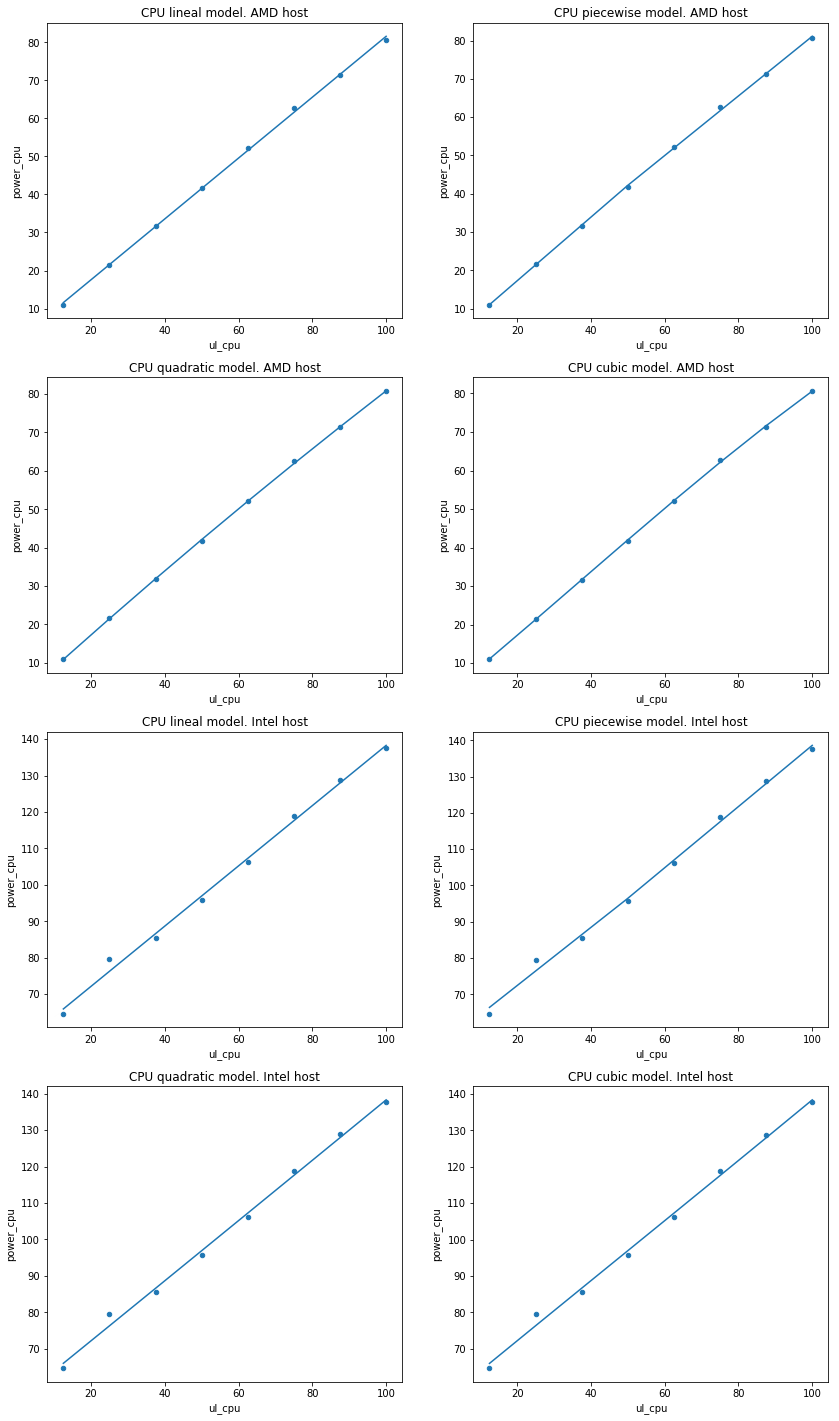

In [85]:
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4, 2, sharey=False, figsize=(14, 25))
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax1)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax2)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax3)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax4)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax5)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax6)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax7)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_cpu', y='power_cpu', ax=ax8)

#AMD
ax1.plot(df_exe_energy_single_amd_pw.ul_cpu, linear_model_amd_cpu.predict())
ax1.set_title('CPU lineal model. AMD host')

ax2.plot(df_exe_energy_single_amd_pw.ul_cpu, piecewise_model_energy_amd_cpu.predict())
ax2.set_title('CPU piecewise model. AMD host')

ax3.plot(df_exe_energy_single_amd_pw.ul_cpu, quadratic_model_energy_amd_cpu.predict())
ax3.set_title('CPU quadratic model. AMD host')

ax4.plot(df_exe_energy_single_amd_pw.ul_cpu, cubic_model_energy_amd_cpu.predict())
ax4.set_title('CPU cubic model. AMD host')

#INTEL
ax5.plot(df_exe_energy_single_intel_pw.ul_cpu, linear_model_intel_cpu.predict())
ax5.set_title('CPU lineal model. Intel host')

ax6.plot(df_exe_energy_single_intel_pw.ul_cpu, piecewise_model_energy_intel_cpu.predict())
ax6.set_title('CPU piecewise model. Intel host')

ax7.plot(df_exe_energy_single_intel_pw.ul_cpu, quadratic_model_energy_intel_cpu.predict())
ax7.set_title('CPU quadratic model. Intel host')

ax8.plot(df_exe_energy_single_intel_pw.ul_cpu, cubic_model_energy_intel_cpu.predict())
ax8.set_title('CPU cubic model. Intel host')




Showing examples of piecewise model usage

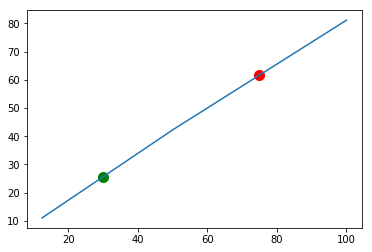

In [86]:

# auxiliar function
H = lambda h: h-50 if h>50 else 0

x = 75
plt.plot(x,piecewise_model_energy_amd_cpu.predict\
         (pd.DataFrame({'ul_cpu': [x],'ul_cpu2': [H(x)]})) , marker='o', markersize=10, color="red")

x = 30
plt.plot(x,piecewise_model_energy_amd_cpu.predict\
         (pd.DataFrame({'ul_cpu': [x],'ul_cpu2': [H(x)]})) , marker='o', markersize=10, color="green")


plt.plot(df_exe_energy_single_amd_pw.ul_cpu, piecewise_model_energy_amd_cpu.predict())
                           


It is posible adjust <strong>MEMORY MODELS </strong> for impoving the R-squared metric. Quadratic and piecewise function is presented below.

In [87]:
ul_mem2 = np.where(df_exe_energy_single_amd_pw['ul_mem'] > 50, df_exe_energy_single_amd_pw['ul_mem'] - 50, 0)
#auxiliar variable
df_exe_energy_single_amd_pw['ul_mem2'] = ul_mem2
piecewise_model_energy_amd_mem = smf.ols(formula = 'power_mem ~ ul_mem + ul_mem2', data = \
                                         df_exe_energy_single_amd_pw).fit()

ul_mem2 = np.where(df_exe_energy_single_amd_pw['ul_mem'] > 50, df_exe_energy_single_amd_pw['ul_mem'] - 50, 0)
df_exe_energy_single_amd_pw['ul_mem2'] = ul_mem2
piecewise_model_energy_intel_mem = smf.ols(formula = 'power_mem ~ ul_mem + ul_mem2', data = \
                                         df_exe_energy_single_intel_pw).fit()

quadratic_model_energy_amd_mem = smf.ols(formula='power_mem ~ ul_mem + np.power(ul_mem,2)', \
                           data=df_exe_energy_single_amd_pw).fit()
quadratic_model_energy_intel_mem = smf.ols(formula='power_mem ~ ul_mem + np.power(ul_mem,2)', \
                           data=df_exe_energy_single_intel_pw).fit()

cubic_model_energy_amd_mem = smf.ols(formula='power_mem ~ ul_mem + np.power(ul_mem,2)  + np.power(ul_mem,3)', \
                           data=df_exe_energy_single_amd_pw).fit()
cubic_model_energy_intel_mem = smf.ols(formula='power_mem ~ ul_mem + np.power(ul_mem,2)  + np.power(ul_mem,3)', \
                           data=df_exe_energy_single_intel_pw).fit()

printing params and summary of improved Memory-bound workload energy models

In [88]:
print ('******************* AMD piecewise energy model - mem bound workload - params *******************')
display (piecewise_model_energy_amd_mem.params)
print (' ')
print ('******************* Intel piecewise energy model - mem bound workload - params *******************')
display (piecewise_model_energy_intel_mem.params)
print (' ')

print ('******************* AMD quadratic energy model - mem bound workload - params *******************')
display (quadratic_model_energy_amd_mem.params)
print (' ')
print ('******************* Intel quadratic energy model - mem bound workload - params *******************')
display (quadratic_model_energy_intel_mem.params)
print (' ')
print ('******************* AMD cubic energy model - mem bound workload - params ***********************')
display (cubic_model_energy_amd_mem.params)
print (' ')
print ('******************* Intel cubic energy model - mem bound workload - params ***********************')
display (cubic_model_energy_intel_mem.params)



******************* AMD piecewise energy model - mem bound workload - params *******************


Intercept    16.012
ul_mem        1.480
ul_mem2      -1.065
dtype: float64

 
******************* Intel piecewise energy model - mem bound workload - params *******************


Intercept    50.131
ul_mem        1.811
ul_mem2      -0.745
dtype: float64

 
******************* AMD quadratic energy model - mem bound workload - params *******************


Intercept              11.269
ul_mem                  1.987
np.power(ul_mem, 2)    -0.010
dtype: float64

 
******************* Intel quadratic energy model - mem bound workload - params *******************


Intercept              44.277
ul_mem                  2.287
np.power(ul_mem, 2)    -0.008
dtype: float64

 
******************* AMD cubic energy model - mem bound workload - params ***********************


Intercept             -3.761e+00
ul_mem                 3.238e+00
np.power(ul_mem, 2)   -3.637e-02
np.power(ul_mem, 3)    1.555e-04
dtype: float64

 
******************* Intel cubic energy model - mem bound workload - params ***********************


Intercept              3.689e+01
ul_mem                 2.902e+00
np.power(ul_mem, 2)   -2.107e-02
np.power(ul_mem, 3)    7.644e-05
dtype: float64

plotting <strong>improved Memory models</strong> 

Text(0.5,1,'mem cubic model. Intel host')

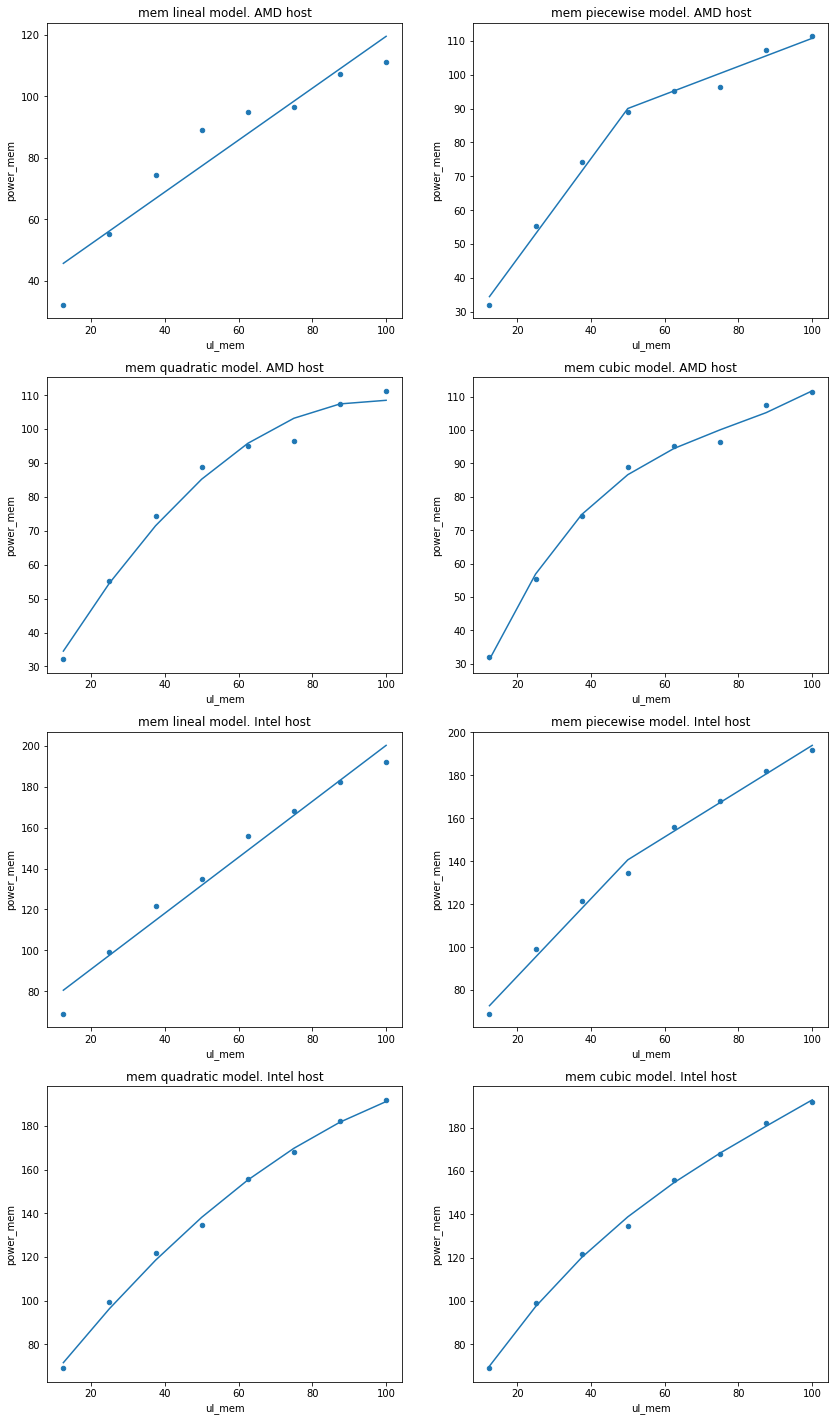

In [89]:
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4, 2, sharey=False, figsize=(14, 25))
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax1)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax2)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax3)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax4)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax5)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax6)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax7)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_mem', y='power_mem', ax=ax8)

#AMD
ax1.plot(df_exe_energy_single_amd_pw.ul_mem, linear_model_amd_mem.predict())
ax1.set_title('mem lineal model. AMD host')

ax2.plot(df_exe_energy_single_amd_pw.ul_mem, piecewise_model_energy_amd_mem.predict())
ax2.set_title('mem piecewise model. AMD host')

ax3.plot(df_exe_energy_single_amd_pw.ul_mem, quadratic_model_energy_amd_mem.predict())
ax3.set_title('mem quadratic model. AMD host')

ax4.plot(df_exe_energy_single_amd_pw.ul_mem, cubic_model_energy_amd_mem.predict())
ax4.set_title('mem cubic model. AMD host')

#INTEL
ax5.plot(df_exe_energy_single_intel_pw.ul_mem, linear_model_intel_mem.predict())
ax5.set_title('mem lineal model. Intel host')

ax6.plot(df_exe_energy_single_intel_pw.ul_mem, piecewise_model_energy_intel_mem.predict())
ax6.set_title('mem piecewise model. Intel host')

ax7.plot(df_exe_energy_single_intel_pw.ul_mem, quadratic_model_energy_intel_mem.predict())
ax7.set_title('mem quadratic model. Intel host')

ax8.plot(df_exe_energy_single_intel_pw.ul_mem, cubic_model_energy_intel_mem.predict())
ax8.set_title('mem cubic model. Intel host')




It is posible adjust <strong>DISK MODELS </strong> for impoving the R-squared metric. Quadratic and piecewise function is presented below.

In [90]:
ul_disk2 = np.where(df_exe_energy_single_amd_pw['ul_disk'] > 50, df_exe_energy_single_amd_pw['ul_disk'] - 50, 0)
#auxiliar variable
df_exe_energy_single_amd_pw['ul_disk2'] = ul_disk2
piecewise_model_energy_amd_disk = smf.ols(formula = 'power_disk ~ ul_disk + ul_disk2', data = \
                                         df_exe_energy_single_amd_pw).fit()

ul_disk2 = np.where(df_exe_energy_single_amd_pw['ul_disk'] > 50, df_exe_energy_single_amd_pw['ul_disk'] - 50, 0)
df_exe_energy_single_amd_pw['ul_disk2'] = ul_disk2
piecewise_model_energy_intel_disk = smf.ols(formula = 'power_disk ~ ul_disk + ul_disk2', data = \
                                         df_exe_energy_single_intel_pw).fit()

quadratic_model_energy_amd_disk = smf.ols(formula='power_disk ~ ul_disk + np.power(ul_disk,2)', \
                           data=df_exe_energy_single_amd_pw).fit()
quadratic_model_energy_intel_disk = smf.ols(formula='power_disk ~ ul_disk + np.power(ul_disk,2)', \
                           data=df_exe_energy_single_intel_pw).fit()

cubic_model_energy_amd_disk = smf.ols(formula='power_disk ~ ul_disk + np.power(ul_disk,2)  + np.power(ul_disk,3)', \
                           data=df_exe_energy_single_amd_pw).fit()
cubic_model_energy_intel_disk = smf.ols(formula='power_disk ~ ul_disk + np.power(ul_disk,2)  + np.power(ul_disk,3)', \
                           data=df_exe_energy_single_intel_pw).fit()

printing params and summary of improved disk-bound workload energy models

In [91]:
print ('******************* AMD piecewise energy model - disk bound workload - params *******************')
display (piecewise_model_energy_amd_disk.params)
print (' ')
print ('******************* Intel piecewise energy model - disk bound workload - params *******************')
display (piecewise_model_energy_intel_disk.params)
print (' ')

print ('******************* AMD quadratic energy model - disk bound workload - params *******************')
display (quadratic_model_energy_amd_disk.params)
print (' ')
print ('******************* Intel quadratic energy model - disk bound workload - params *******************')
display (quadratic_model_energy_intel_disk.params)
print (' ')
print ('******************* AMD cubic energy model - disk bound workload - params ***********************')
display (cubic_model_energy_amd_disk.params)
print (' ')
print ('******************* Intel cubic energy model - disk bound workload - params ***********************')
display (cubic_model_energy_intel_disk.params)



******************* AMD piecewise energy model - disk bound workload - params *******************


Intercept    4.701
ul_disk      0.031
ul_disk2    -0.012
dtype: float64

 
******************* Intel piecewise energy model - disk bound workload - params *******************


Intercept    9.849
ul_disk      0.042
ul_disk2     0.031
dtype: float64

 
******************* AMD quadratic energy model - disk bound workload - params *******************


Intercept               4.457e+00
ul_disk                 4.553e-02
np.power(ul_disk, 2)   -1.921e-04
dtype: float64

 
******************* Intel quadratic energy model - disk bound workload - params *******************


Intercept               9.911e+00
ul_disk                 3.056e-02
np.power(ul_disk, 2)    2.621e-04
dtype: float64

 
******************* AMD cubic energy model - disk bound workload - params ***********************


Intercept               4.162e+00
ul_disk                 7.011e-02
np.power(ul_disk, 2)   -7.077e-04
np.power(ul_disk, 3)    3.055e-06
dtype: float64

 
******************* Intel cubic energy model - disk bound workload - params ***********************


Intercept               1.120e+01
ul_disk                -7.645e-02
np.power(ul_disk, 2)    2.506e-03
np.power(ul_disk, 3)   -1.330e-05
dtype: float64

plotting <strong>improved Disk models</strong> 

0    4.737
1    5.885
2    6.074
3    5.900
4    6.452
5    6.707
6    7.306
7    6.959
Name: power_disk, dtype: float64

Text(0.5,1,'disk cubic model. Intel host')

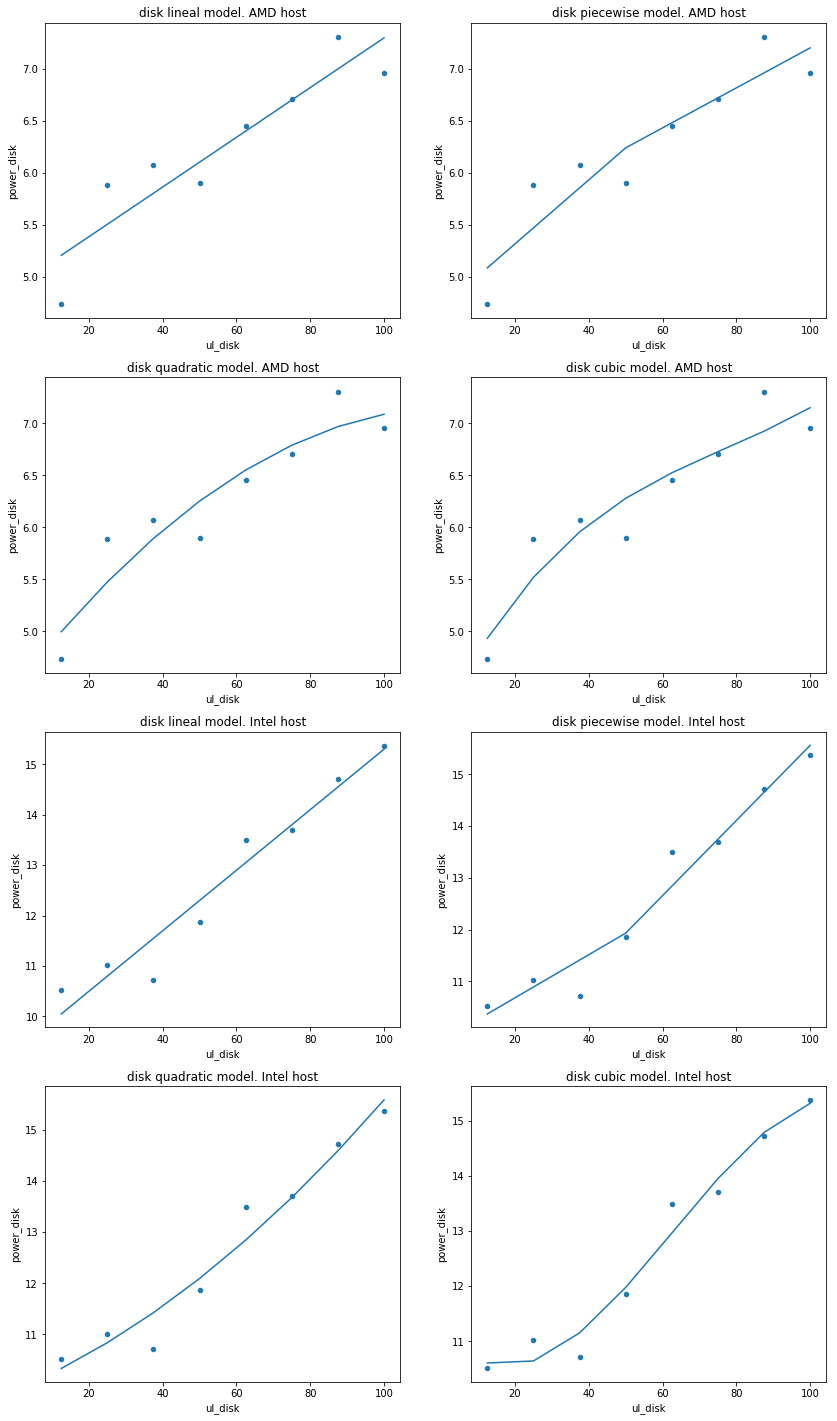

In [92]:

display(df_exe_energy_single_amd_pw['power_disk'])

f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4, 2, sharey=False, figsize=(14, 25))
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax1)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax2)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax3)
df_exe_energy_single_amd_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax4)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax5)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax6)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax7)
df_exe_energy_single_intel_pw.plot(kind='scatter', x='ul_disk', y='power_disk', ax=ax8)

#AMD
ax1.plot(df_exe_energy_single_amd_pw.ul_disk, linear_model_amd_disk.predict())
ax1.set_title('disk lineal model. AMD host')

ax2.plot(df_exe_energy_single_amd_pw.ul_disk, piecewise_model_energy_amd_disk.predict())
ax2.set_title('disk piecewise model. AMD host')

ax3.plot(df_exe_energy_single_amd_pw.ul_disk, quadratic_model_energy_amd_disk.predict())
ax3.set_title('disk quadratic model. AMD host')

ax4.plot(df_exe_energy_single_amd_pw.ul_disk, cubic_model_energy_amd_disk.predict())
ax4.set_title('disk cubic model. AMD host')

#INTEL
ax5.plot(df_exe_energy_single_intel_pw.ul_disk, linear_model_intel_disk.predict())
ax5.set_title('disk lineal model. Intel host')

ax6.plot(df_exe_energy_single_intel_pw.ul_disk, piecewise_model_energy_intel_disk.predict())
ax6.set_title('disk piecewise model. Intel host')

ax7.plot(df_exe_energy_single_intel_pw.ul_disk, quadratic_model_energy_intel_disk.predict())
ax7.set_title('disk quadratic model. Intel host')

ax8.plot(df_exe_energy_single_intel_pw.ul_disk, cubic_model_energy_intel_disk.predict())
ax8.set_title('disk cubic model. Intel host')


Rsquared metric for energy models. Best models regarding rsquared are highlighted

In [93]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]


print ('******************* energy model - CPU bound workload - rsquared *******************')
energy_model_CPU_bound_workload_rsquared = pd.DataFrame(
[
    ['x',linear_model_amd_cpu.rsquared,linear_model_intel_cpu.rsquared],
    ['x + xaux',piecewise_model_energy_amd_cpu.rsquared,piecewise_model_energy_intel_cpu.rsquared],
    ['x^2',quadratic_model_energy_amd_cpu.rsquared,quadratic_model_energy_intel_cpu.rsquared],
    ['x^3',cubic_model_energy_amd_cpu.rsquared,cubic_model_energy_intel_cpu.rsquared],
 
]
)

pd.set_option('precision', 5)
energy_model_CPU_bound_workload_rsquared.columns=['MODEL','AMDRSQUARED','INTELRSQUARED']
display(energy_model_CPU_bound_workload_rsquared.style.apply(highlight_max, subset=['AMDRSQUARED','INTELRSQUARED']))
print (' ')


print ('******************* energy model - mem bound workload - rsquared *******************')
energy_model_mem_bound_workload_rsquared = pd.DataFrame(
[
    ['x',linear_model_amd_mem.rsquared,linear_model_intel_mem.rsquared],
    ['x + xaux',piecewise_model_energy_amd_mem.rsquared,piecewise_model_energy_intel_mem.rsquared],
    ['x^2',quadratic_model_energy_amd_mem.rsquared,quadratic_model_energy_intel_mem.rsquared],
    ['x^3',cubic_model_energy_amd_mem.rsquared,cubic_model_energy_intel_mem.rsquared],
 
]
)

pd.set_option('precision', 5)
energy_model_mem_bound_workload_rsquared.columns=['MODEL','AMDRSQUARED','INTELRSQUARED']
display(energy_model_mem_bound_workload_rsquared.style.apply(highlight_max, subset=['AMDRSQUARED','INTELRSQUARED']))
print (' ')

print ('******************* energy model - disk bound workload - rsquared *******************')
energy_model_disk_bound_workload_rsquared = pd.DataFrame(
[
    ['x',linear_model_amd_disk.rsquared,linear_model_intel_disk.rsquared],
    ['x + xaux',piecewise_model_energy_amd_disk.rsquared,piecewise_model_energy_intel_disk.rsquared],
    ['x^2',quadratic_model_energy_amd_disk.rsquared,quadratic_model_energy_intel_disk.rsquared],
    ['x^3',cubic_model_energy_amd_disk.rsquared,cubic_model_energy_intel_disk.rsquared],
 
]
)

pd.set_option('precision', 5)
energy_model_disk_bound_workload_rsquared.columns=['MODEL','AMDRSQUARED','INTELRSQUARED']
display(energy_model_disk_bound_workload_rsquared.style.apply(highlight_max, subset=['AMDRSQUARED','INTELRSQUARED']))
print (' ')

******************* energy model - CPU bound workload - rsquared *******************


,MODEL,AMDRSQUARED,INTELRSQUARED
0,x,0.99937,0.99584
1,x + xaux,0.99964,0.99599
2,x^2,0.99979,0.99584
3,x^3,0.99986,0.99584


 
******************* energy model - mem bound workload - rsquared *******************


,MODEL,AMDRSQUARED,INTELRSQUARED
0,x,0.90313,0.9749
1,x + xaux,0.99252,0.99294
2,x^2,0.9843,0.99666
3,x^3,0.99483,0.99772


 
******************* energy model - disk bound workload - rsquared *******************


,MODEL,AMDRSQUARED,INTELRSQUARED
0,x,0.84465,0.94454
1,x + xaux,0.85695,0.96016
2,x^2,0.87868,0.95579
3,x^3,0.88344,0.97179


# step 9: combined  computational resource


In this step combined power consumption of combined in pairs experiment are generated. The following dataframe contains the complete infomrmation for modeling

In [94]:
new_cols = ['ULx', 'ULy', 
            'AMDcpumem', 'AMDcpumemec', \
            'AMDcpudisk', 'AMDcpudiskec', \
            'AMDmemdisk', 'AMDmemdiskec', \
            'Intelcpumem', 'Intel_cpu_mem_ec', \
            'Intelcpudisk', 'Intelcpudiskec', \
            'Intelmemdisk', 'Intelmemdiskec']
df_double_result.columns = new_cols



# complete cdata of combined experiments with independents experiments
aux = pd.DataFrame([
    [25,0,
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 25]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 25]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 25]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 25]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 25]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 25]['power_average'])-INTEL_IDLE_PC,
    ],
    [50, 0,
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 50]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 50]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 50]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 50]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 50]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 50]['power_average'])-INTEL_IDLE_PC,
      ],
    [75, 0,
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 75]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 75]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 75]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 75]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 75]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_m2_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_m2_pw.UL == 75]['power_average'])-INTEL_IDLE_PC,
      ],
    [100, 0,
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 100]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_amd_c1_pw[df_exe_energy_single_amd_c1_pw.UL == 100]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 100]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 100]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_c1_pw.UL == 100]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_m2_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_intel_c1_pw[df_exe_energy_single_intel_m2_pw.UL == 100]['power_average'])-INTEL_IDLE_PC,
    ],
    [0, 25,
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 25]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 25]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 25]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 25]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 25]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 25]['power_average']),
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 25]['power_average'])-INTEL_IDLE_PC,
    ],
    [0, 50,
      float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 50]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 50]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 50]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 50]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 50]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 50]['power_average']),
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 50]['power_average'])-INTEL_IDLE_PC,
    ],
    [0, 75,
      float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 75]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 75]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 75]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 75]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 75]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 75]['power_average']),
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 75]['power_average'])-INTEL_IDLE_PC,
    ],
    [0, 100,
       float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_amd_m2_pw[df_exe_energy_single_amd_m2_pw.UL == 100]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 100]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_amd_f1_pw[df_exe_energy_single_amd_f1_pw.UL == 100]['power_average'])-AMD_IDLE_PC,
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_intel_m2_pw[df_exe_energy_single_intel_m2_pw.UL == 100]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 100]['power_average'])-INTEL_IDLE_PC,
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 100]['power_average']),
     float(df_exe_energy_single_intel_f1_pw[df_exe_energy_single_intel_f1_pw.UL == 100]['power_average'])-INTEL_IDLE_PC,
    ],

])

aux.columns = new_cols

df_double_result = df_double_result.append(aux)
display(df_double_result)





,ULx,ULy,AMDcpumem,AMDcpumemec,AMDcpudisk,AMDcpudiskec,AMDmemdisk,AMDmemdiskec,Intelcpumem,Intel_cpu_mem_ec,Intelcpudisk,Intelcpudiskec,Intelmemdisk,Intelmemdiskec
0,25,25,259.44485,76.04485,210.00745,26.60745,243.93701,60.53701,264.13829,207.13829,136.38245,79.38245,174.05643,117.05643
1,25,50,290.30830,106.90830,211.52344,28.12344,241.75416,58.35416,296.51625,239.51625,139.01913,82.01913,176.21685,119.21685
2,25,75,312.74651,129.34651,212.36642,28.96642,245.91589,62.51589,325.57446,268.57446,137.19094,80.19094,172.03628,115.03628
3,50,25,277.10105,93.70105,229.79805,46.39805,268.22676,84.82676,279.12393,222.12393,154.17355,97.17355,206.43483,149.43483
4,50,50,310.30444,126.90444,234.32925,50.92925,269.53809,86.13809,320.39851,263.39851,156.47872,99.47872,208.55162,151.55162
5,75,25,295.75674,112.35674,248.41991,65.01991,286.96990,103.56990,302.25136,245.25136,177.82625,120.82625,228.51217,171.51217
0,25,0,204.95176,21.55176,204.95176,21.55176,238.66391,55.26391,136.55242,79.55242,136.55242,79.55242,156.34169,99.34169
1,50,0,225.05016,41.65016,225.05016,41.65016,272.34856,88.94856,152.80044,95.80044,152.80044,95.80044,191.75690,134.75690
2,75,0,246.02218,62.62218,246.02218,62.62218,279.89199,96.49199,175.76972,118.76972,175.76972,118.76972,175.76972,118.76972
3,100,0,264.06843,80.66843,264.06843,80.66843,294.70177,111.30177,194.64020,137.64020,194.64020,137.64020,194.64020,137.64020


linear and quadratic models for power consumption of cpu and memory bound workload execution together

In [95]:
linear_model_energy_AMD_cpumem = smf.ols(formula='AMDcpumem  ~  ULx + ULy', \
                           data=df_double_result).fit()
linear_model_energy_intel_cpumem = smf.ols(formula='Intelcpumem  ~  ULx + ULy', \
                           data=df_double_result).fit()

linear_model_energy_AMD_cpudisk = smf.ols(formula='AMDcpudisk  ~  ULx + ULy', \
                           data=df_double_result).fit()
linear_model_energy_intel_cpudisk = smf.ols(formula='Intelcpudisk  ~  ULx + ULy', \
                           data=df_double_result).fit()

linear_model_energy_AMD_memdisk = smf.ols(formula='AMDmemdisk  ~  ULx + ULy', \
                           data=df_double_result).fit()
linear_model_energy_intel_memdisk = smf.ols(formula='Intelmemdisk  ~  ULx + ULy', \
                           data=df_double_result).fit()


quadratic_model_energy_AMD_cpumem = smf.ols(formula='AMDcpumem  ~  ULx + ULy + ULx * ULy + np.power(ULx,2) + np.power(ULy,2)', \
                           data=df_double_result).fit()
quadratic_model_energy_intel_cpumem = smf.ols(formula='Intelcpumem  ~  ULx + ULy + ULx * ULy + np.power(ULx,2) + np.power(ULy,2)', \
                           data=df_double_result).fit()

quadratic_model_energy_AMD_cpudisk = smf.ols(formula='AMDcpudisk  ~  ULx + ULy + ULx * ULy + np.power(ULx,2) + np.power(ULy,2)', \
                           data=df_double_result).fit()
quadratic_model_energy_intel_cpudisk = smf.ols(formula='Intelcpudisk  ~  ULx + ULy + ULx * ULy + np.power(ULx,2) + np.power(ULy,2)', \
                           data=df_double_result).fit()

quadratic_model_energy_AMD_memdisk = smf.ols(formula='AMDmemdisk  ~  ULx + ULy + ULx * ULy + np.power(ULx,2) + np.power(ULy,2)', \
                           data=df_double_result).fit()
quadratic_model_energy_intel_memdisk = smf.ols(formula='Intelmemdisk  ~  ULx + ULy + ULx * ULy + np.power(ULx,2) + np.power(ULy,2)', \
                           data=df_double_result).fit()



params

In [96]:
print ('******************* AMD linear energy model - cpu mem bound workload - params *******************')
display (linear_model_energy_AMD_cpumem.params)
print (' ')

print ('******************* Intel linear energy model - cpu mem bound workload - params *******************')
display (linear_model_energy_intel_cpumem.params)
print (' ')

print ('******************* AMD linear energy model - cpu disk bound workload - params *******************')
display (linear_model_energy_AMD_cpudisk.params)
print (' ')

print ('******************* Intel linear energy model - cpu disk bound workload - params *******************')
display (linear_model_energy_intel_cpudisk.params)
print (' ')

print ('******************* AMD linear energy model - mem disk bound workload - params *******************')
display (linear_model_energy_AMD_memdisk.params)
print (' ')

print ('******************* Intel linear energy model - mem disk bound workload - params *******************')
display (linear_model_energy_intel_memdisk.params)
print (' ')



print ('******************* AMD quadratic energy model - cpu mem bound workload - params *******************')
display (quadratic_model_energy_AMD_cpumem.params)
print (' ')

print ('******************* Intel quadratic energy model - cpu mem bound workload - params *******************')
display (quadratic_model_energy_intel_cpumem.params)
print (' ')

print ('******************* AMD quadratic energy model - cpu disk bound workload - params *******************')
display (quadratic_model_energy_AMD_cpudisk.params)
print (' ')

print ('******************* Intel quadratic energy model - cpu disk bound workload - params *******************')
display (quadratic_model_energy_intel_cpudisk.params)
print (' ')

print ('******************* AMD quadratic energy model - mem disk bound workload - params *******************')
display (quadratic_model_energy_AMD_memdisk.params)
print (' ')

print ('******************* Intel quadratic energy model - mem disk bound workload - params *******************')
display (quadratic_model_energy_intel_memdisk.params)
print (' ')



******************* AMD linear energy model - cpu mem bound workload - params *******************


Intercept    201.69767
ULx            0.71923
ULy            1.17596
dtype: float64

 
******************* Intel linear energy model - cpu mem bound workload - params *******************


Intercept    112.74296
ULx            1.39039
ULy            1.99255
dtype: float64

 
******************* AMD linear energy model - cpu disk bound workload - params *******************


Intercept    186.30660
ULx            0.80309
ULy            0.07151
dtype: float64

 
******************* Intel linear energy model - cpu disk bound workload - params *******************


Intercept    88.88702
ULx           1.24615
ULy          -0.05342
dtype: float64

 
******************* AMD linear energy model - mem disk bound workload - params *******************


Intercept    204.40903
ULx            1.11686
ULy           -0.03832
dtype: float64

 
******************* Intel linear energy model - mem disk bound workload - params *******************


Intercept    99.70075
ULx           1.50079
ULy           0.03613
dtype: float64

 
******************* AMD quadratic energy model - cpu mem bound workload - params *******************


Intercept           191.22728
ULx                   0.65870
ULy                   2.11943
ULx:ULy               0.00331
np.power(ULx, 2)      0.00069
np.power(ULy, 2)     -0.01112
dtype: float64

 
******************* Intel quadratic energy model - cpu mem bound workload - params *******************


Intercept           82.08146
ULx                  2.54136
ULy                  3.53307
ULx:ULy              0.01815
np.power(ULx, 2)    -0.01509
np.power(ULy, 2)    -0.01968
dtype: float64

 
******************* AMD quadratic energy model - cpu disk bound workload - params *******************


Intercept           185.53086
ULx                   0.81697
ULy                   0.13433
ULx:ULy               0.00115
np.power(ULx, 2)     -0.00032
np.power(ULy, 2)     -0.00090
dtype: float64

 
******************* Intel quadratic energy model - cpu disk bound workload - params *******************


Intercept           82.59147
ULx                  2.10859
ULy                 -0.34114
ULx:ULy              0.00549
np.power(ULx, 2)    -0.01078
np.power(ULy, 2)     0.00275
dtype: float64

 
******************* AMD quadratic energy model - mem disk bound workload - params *******************


Intercept           193.79456
ULx                   2.07529
ULy                  -0.11013
ULx:ULy               0.00267
np.power(ULx, 2)     -0.01118
np.power(ULy, 2)      0.00094
dtype: float64

 
******************* Intel quadratic energy model - mem disk bound workload - params *******************


Intercept           81.97649
ULx                  3.32256
ULy                 -0.16404
ULx:ULy              0.01575
np.power(ULx, 2)    -0.02326
np.power(ULy, 2)     0.00053
dtype: float64

rsquared

In [97]:
pd.set_option('precision', 8)
print ('******************* energy model - cpu mem bound workload - rsquared *******************')
energy_model_AMD_cpu_mem_workload_rsquared = pd.DataFrame(
[
    ['x',linear_model_energy_AMD_cpumem.rsquared,linear_model_energy_intel_cpumem.rsquared],
     ['x^2',quadratic_model_energy_AMD_cpumem.rsquared,quadratic_model_energy_intel_cpumem.rsquared],
   
]
)

energy_model_AMD_cpu_mem_workload_rsquared.columns=['MODEL','AMDRSQUARED','INTELRSQUARED']
display(energy_model_AMD_cpu_mem_workload_rsquared.style.apply(highlight_max, subset=['AMDRSQUARED','INTELRSQUARED']))
print (' ')

print ('******************* energy model - cpu disk bound workload - rsquared *******************')
energy_model_AMD_cpu_disk_workload_rsquared = pd.DataFrame(
[
    ['x',linear_model_energy_AMD_cpudisk.rsquared,linear_model_energy_intel_cpudisk.rsquared],
     ['x^2',quadratic_model_energy_AMD_cpudisk.rsquared,quadratic_model_energy_intel_cpudisk.rsquared],
   
]
)

energy_model_AMD_cpu_disk_workload_rsquared.columns=['MODEL','AMDRSQUARED','INTELRSQUARED']
display(energy_model_AMD_cpu_disk_workload_rsquared.style.apply(highlight_max, subset=['AMDRSQUARED','INTELRSQUARED']))
print (' ')



print ('******************* energy model - mem disk bound workload - rsquared *******************')
energy_model_AMD_mem_disk_workload_rsquared = pd.DataFrame(
[
    ['x',linear_model_energy_AMD_memdisk.rsquared,linear_model_energy_intel_memdisk.rsquared],
     ['x^2',quadratic_model_energy_AMD_memdisk.rsquared,quadratic_model_energy_intel_memdisk.rsquared],
   
]
)

energy_model_AMD_mem_disk_workload_rsquared.columns=['MODEL','AMDRSQUARED','INTELRSQUARED']
display(energy_model_AMD_mem_disk_workload_rsquared.style.apply(highlight_max, subset=['AMDRSQUARED','INTELRSQUARED']))
print (' ')




******************* energy model - cpu mem bound workload - rsquared *******************


,MODEL,AMDRSQUARED,INTELRSQUARED
0,x,0.8383211,0.56744014
1,x^2,0.99156392,0.93706683


 
******************* energy model - cpu disk bound workload - rsquared *******************


,MODEL,AMDRSQUARED,INTELRSQUARED
0,x,0.9933666,0.87970045
1,x^2,0.99885306,0.96577669


 
******************* energy model - mem disk bound workload - rsquared *******************


,MODEL,AMDRSQUARED,INTELRSQUARED
0,x,0.89327219,0.66065867
1,x^2,0.99061396,0.96316125


preparing data of triple execution experiments

In [156]:
o = df_exe_energy_triple_amd_pw_c1m2f1.copy()
o=pd.concat([o,df_exe_energy_triple_intel_pw_c1m2f1['power_average']],axis=1)

new_cols = ['ULx', 'ULy','ULz','PC_AMD','PC_INTEL']

o.head()
# complete cdata of combined experiments with independents experiments
aux = pd.DataFrame([
    [25,0,0,
    float(df_exe_energy_single_amd_c1_pw.query('UL == 25').power_average),
    float(df_exe_energy_single_intel_c1_pw.query('UL == 25').power_average),
    ],
    [0,25,0,
    float(df_exe_energy_single_amd_m2_pw.query('UL == 25').power_average),
    float(df_exe_energy_single_intel_m2_pw.query('UL == 25').power_average),
    ],
    [0,0,25,
    float(df_exe_energy_single_amd_f1_pw.query('UL == 25').power_average),
    float(df_exe_energy_single_intel_f1_pw.query('UL == 25').power_average),
    ],
    [25,25,0,
    float(df_double_result.query('ULx == 25 and ULy == 25').AMDcpumem),
    float(df_double_result.query('ULx == 25 and ULy == 25').Intelcpumem)
    ],  
    [25,0,25,
    float(df_double_result.query('ULx == 25 and ULy == 25').AMDcpudisk),
    float(df_double_result.query('ULx == 25 and ULy == 25').Intelcpudisk)
    ],  
    [0,25,25,
    float(df_double_result.query('ULx == 25 and ULy == 25').AMDmemdisk),
    float(df_double_result.query('ULx == 25 and ULy == 25').Intelmemdisk)
    ],  
    
    ])
o.columns = new_cols
aux.columns = new_cols
triple_energy_executions_ready = o.append(aux)
display(triple_energy_executions_ready)
 




,ULx,ULy,ULz,PC_AMD,PC_INTEL
0,25,25,25,266.31626,177.37168
1,25,25,50,266.92783,178.71528
2,25,50,25,303.23381,220.86097
3,50,25,25,288.10379,194.99217
0,25,0,0,204.95176,136.55242
1,0,25,0,238.66391,156.34169
2,0,0,25,189.28527,68.01776
3,25,25,0,259.44485,264.13829
4,25,0,25,210.00745,136.38245
5,0,25,25,243.93701,174.05643


modeling triple execution

In [194]:
linear_model_energy_AMD_cpumemdisk = smf.ols(formula='PC_AMD  ~  ULx + ULy + ULz', \
                           data=triple_energy_executions_ready).fit()
linear_model_energy_intel_cpumemdisk = smf.ols(formula='PC_INTEL  ~  ULx + ULy + ULz', \
                           data=triple_energy_executions_ready).fit()

cubic_model_energy_AMD_cpumemdisk = smf.ols(formula='PC_AMD  ~  ULx + ULy + ULz + \

ULx * ULy + \
ULx * ULz + \
ULy * ULz + \
np.power(ULx,2) + \
np.power(ULy,2) + \
np.power(ULz,2) + \
np.power(ULx,2) * ULy  + \
np.power(ULx,2) * ULz  + \
np.power(ULy,2) * ULx  + \
ULx * ULy * ULz + \
np.power(ULx,3)+ np.power(ULy,3) + np.power(ULz,3)',\
                           data=triple_energy_executions_ready).fit()




SyntaxError: EOL while scanning string literal (<ipython-input-194-1311a1de550d>, line 4)

params

In [191]:
print ('******************* AMD linear energy model - cpu mem disk bound workload - params *******************')
display (linear_model_energy_AMD_cpumemdisk.params)
print (' ')

print ('******************* Intel linear energy model - cpu mem disk bound workload - params *******************')
display (linear_model_energy_intel_cpumemdisk.params)
print (' ')

print ('******************* Intel cubic energy model - cpu mem disk bound workload - params *******************')
display (cubic_model_energy_AMD_cpumemdisk.params)
print (' ')



******************* AMD linear energy model - cpu mem disk bound workload - params *******************


Intercept    186.82096
ULx            0.86923
ULy            1.97285
ULz            0.17123
dtype: float64

 
******************* Intel linear energy model - cpu mem disk bound workload - params *******************


Intercept    116.97208
ULx            1.30312
ULy            2.41421
ULz           -1.02879
dtype: float64

 
******************* Intel cubic energy model - cpu mem disk bound workload - params *******************


Intercept           0.00507
ULx                 0.02943
ULy                 0.03471
ULz                 0.02731
np.power(ULx, 2)    0.49034
ULx:ULy            -0.29467
ULx:ULz            -0.29476
np.power(ULy, 2)    0.57845
ULy:ULz            -0.29441
np.power(ULz, 2)    0.45514
ULx:ULy:ULz         0.01189
np.power(ULx, 3)   -0.00654
np.power(ULy, 3)   -0.00792
np.power(ULz, 3)   -0.00614
dtype: float64

# step 10: performance models

From performance experiments it is able to generate performance models. THe following dataframe contains the complete information of performance experiments and it is the input for modeling 

In [99]:
X_theoretical = pd.DataFrame({'UL': [0, 100]})

df_exe_performance_single= pd.concat([df_exe_performance_single_amd_pw_c1unt,\
                    df_exe_performance_single_amd_pw_m2unt['seconds'],\
                    df_exe_performance_single_amd_pw_f1unt['seconds'],\
                   df_exe_performance_single_intel_pw_c1unt['seconds'],\
                    df_exe_performance_single_intel_pw_m2unt['seconds'],\
                    df_exe_performance_single_intel_pw_f1unt['seconds']],\
                  axis=1) 

df_exe_performance_single.columns = ['UL', 'makespan_amd_cpu', 'makespan_amd_mem', 'makespan_amd_disk',\
                                         'makespan_intel_cpu', 'makespan_intel_mem', 'makespan_intel_disk']

df_exe_performance_single.head()

,UL,makespan_amd_cpu,makespan_amd_mem,makespan_amd_disk,makespan_intel_cpu,makespan_intel_mem,makespan_intel_disk
0,12.5,44.35000000,90.20,234.70,35.80,34.60,36.05
1,25.0,44.85714286,136.75,547.70,30.35,26.55,74.05
2,37.5,45.00000000,179.75,839.40,36.25,41.10,114.70
3,50.0,45.00000000,220.75,1397.85,30.75,41.75,154.50
4,62.5,45.00000000,259.10,1644.05,29.50,67.45,195.90


linear, piecewise, quadratic and cubic models are generated as follows

  performance models of CPU bound workload

In [100]:
#AMD
linear_model_performance_amd_cpu = smf.ols(formula='makespan_amd_cpu ~ UL', \
                           data=df_exe_performance_single).fit()


UL2 = np.where(df_exe_energy_single_amd_pw['ul_mem'] > 50, df_exe_energy_single_amd_pw['ul_mem'] - 50, 0)
#auxiliar variable
df_exe_energy_single_amd_pw['UL2'] = UL2
piecewise_model_performance_amd_cpu = smf.ols(formula = 'makespan_amd_cpu ~ UL + UL2', data = \
                                         df_exe_performance_single).fit()

quadratic_model_performance_amd_cpu = smf.ols(formula='makespan_amd_cpu ~ UL + np.power(UL,2)', \
                                              data=df_exe_performance_single).fit()


cubic_model_performance_amd_cpu = smf.ols(formula='makespan_amd_cpu ~ UL + np.power(UL,2)+ np.power(UL,3)', \
                                              data=df_exe_performance_single).fit()


#intel
linear_model_performance_intel_cpu = smf.ols(formula='makespan_intel_cpu ~ UL', \
                           data=df_exe_performance_single).fit()


UL2 = np.where(df_exe_energy_single_intel_pw['ul_mem'] > 50, df_exe_energy_single_intel_pw['ul_mem'] - 50, 0)
#auxiliar variable
df_exe_energy_single_intel_pw['UL2'] = UL2
piecewise_model_performance_intel_cpu = smf.ols(formula = 'makespan_intel_cpu ~ UL + UL2', data = \
                                         df_exe_performance_single).fit()

quadratic_model_performance_intel_cpu = smf.ols(formula='makespan_intel_cpu ~ UL + np.power(UL,2)', \
                                              data=df_exe_performance_single).fit()


cubic_model_performance_intel_cpu = smf.ols(formula='makespan_intel_cpu ~ UL + np.power(UL,2)+ np.power(UL,3)', \
                                              data=df_exe_performance_single).fit()






plotting <strong>performance CPU bound models</strong> 

Text(0.5,1,'cubic performance model. cpu. intel host')

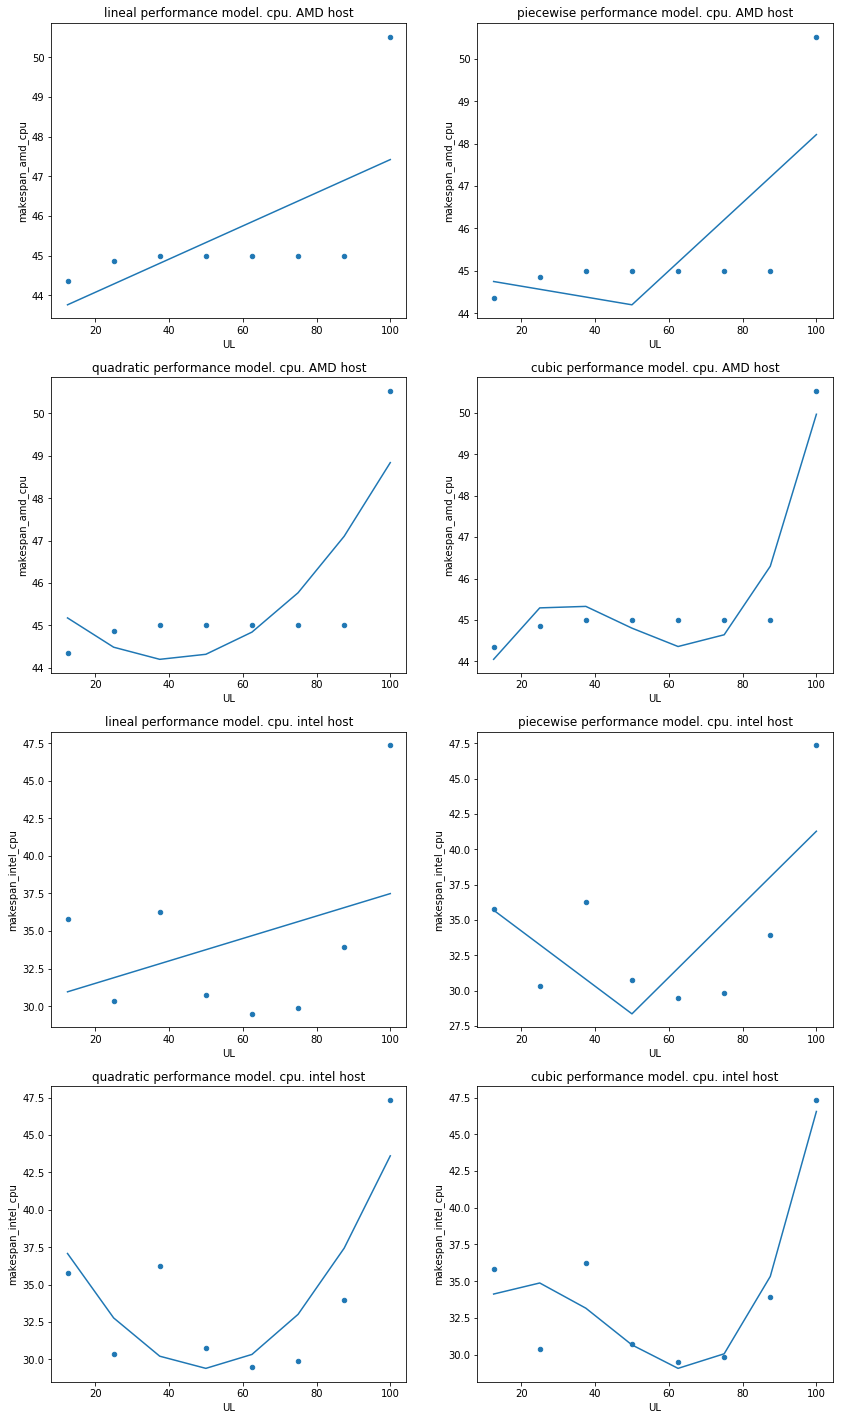

In [101]:
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4, 2, sharey=False, figsize=(14, 25))
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_cpu', ax=ax1)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_cpu', ax=ax2)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_cpu', ax=ax3)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_cpu', ax=ax4)

df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_cpu', ax=ax5)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_cpu', ax=ax6)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_cpu', ax=ax7)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_cpu', ax=ax8)


#AMD
ax1.plot(df_exe_performance_single.UL, linear_model_performance_amd_cpu.predict())
ax1.set_title('lineal performance model. cpu. AMD host')

ax2.plot(df_exe_performance_single.UL, piecewise_model_performance_amd_cpu.predict())
ax2.set_title('piecewise performance model. cpu. AMD host')

ax3.plot(df_exe_performance_single.UL, quadratic_model_performance_amd_cpu.predict())
ax3.set_title('quadratic performance model. cpu. AMD host')

ax4.plot(df_exe_performance_single.UL, cubic_model_performance_amd_cpu.predict())
ax4.set_title('cubic performance model. cpu. AMD host')

#INTEL
ax5.plot(df_exe_performance_single.UL, linear_model_performance_intel_cpu.predict())
ax5.set_title('lineal performance model. cpu. intel host')

ax6.plot(df_exe_performance_single.UL, piecewise_model_performance_intel_cpu.predict())
ax6.set_title('piecewise performance model. cpu. intel host')

ax7.plot(df_exe_performance_single.UL, quadratic_model_performance_intel_cpu.predict())
ax7.set_title('quadratic performance model. cpu. intel host')

ax8.plot(df_exe_performance_single.UL, cubic_model_performance_intel_cpu.predict())
ax8.set_title('cubic performance model. cpu. intel host')





  performance models of memory bound workload

In [102]:
#AMD
linear_model_performance_amd_mem = smf.ols(formula='makespan_amd_mem ~ UL', \
                           data=df_exe_performance_single).fit()


UL2 = np.where(df_exe_energy_single_amd_pw['ul_mem'] > 50, df_exe_energy_single_amd_pw['ul_mem'] - 50, 0)
#auxiliar variable
df_exe_energy_single_amd_pw['UL2'] = UL2
piecewise_model_performance_amd_mem = smf.ols(formula = 'makespan_amd_mem ~ UL + UL2', data = \
                                         df_exe_performance_single).fit()

quadratic_model_performance_amd_mem = smf.ols(formula='makespan_amd_mem ~ UL + np.power(UL,2)', \
                                              data=df_exe_performance_single).fit()


cubic_model_performance_amd_mem = smf.ols(formula='makespan_amd_mem ~ UL + np.power(UL,2)+ np.power(UL,3)', \
                                              data=df_exe_performance_single).fit()


#intel
linear_model_performance_intel_mem = smf.ols(formula='makespan_intel_mem ~ UL', \
                           data=df_exe_performance_single).fit()


UL2 = np.where(df_exe_energy_single_intel_pw['ul_mem'] > 50, df_exe_energy_single_intel_pw['ul_mem'] - 50, 0)
#auxiliar variable
df_exe_energy_single_intel_pw['UL2'] = UL2
piecewise_model_performance_intel_mem = smf.ols(formula = 'makespan_intel_mem ~ UL + UL2', data = \
                                         df_exe_performance_single).fit()

quadratic_model_performance_intel_mem = smf.ols(formula='makespan_intel_mem ~ UL + np.power(UL,2)', \
                                              data=df_exe_performance_single).fit()


cubic_model_performance_intel_mem = smf.ols(formula='makespan_intel_mem ~ UL + np.power(UL,2)+ np.power(UL,3)', \
                                              data=df_exe_performance_single).fit()






plotting <strong>performance memory bound models</strong> 

Text(0.5,1,'cubic performance model. mem. intel host')

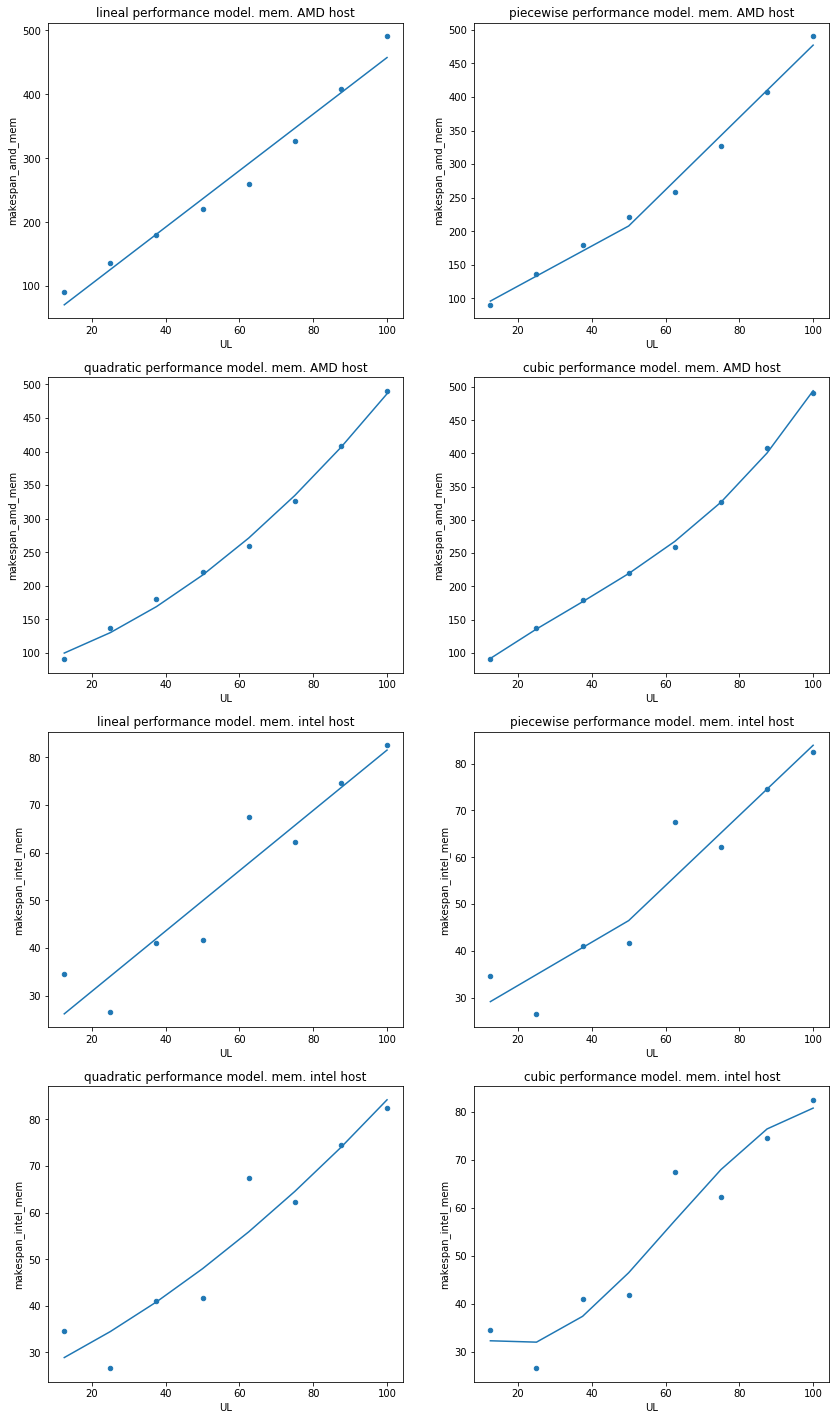

In [103]:
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4, 2, sharey=False, figsize=(14, 25))
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_mem', ax=ax1)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_mem', ax=ax2)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_mem', ax=ax3)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_mem', ax=ax4)

df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_mem', ax=ax5)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_mem', ax=ax6)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_mem', ax=ax7)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_mem', ax=ax8)


#AMD
ax1.plot(df_exe_performance_single.UL, linear_model_performance_amd_mem.predict())
ax1.set_title('lineal performance model. mem. AMD host')

ax2.plot(df_exe_performance_single.UL, piecewise_model_performance_amd_mem.predict())
ax2.set_title('piecewise performance model. mem. AMD host')

ax3.plot(df_exe_performance_single.UL, quadratic_model_performance_amd_mem.predict())
ax3.set_title('quadratic performance model. mem. AMD host')

ax4.plot(df_exe_performance_single.UL, cubic_model_performance_amd_mem.predict())
ax4.set_title('cubic performance model. mem. AMD host')

#INTEL
ax5.plot(df_exe_performance_single.UL, linear_model_performance_intel_mem.predict())
ax5.set_title('lineal performance model. mem. intel host')

ax6.plot(df_exe_performance_single.UL, piecewise_model_performance_intel_mem.predict())
ax6.set_title('piecewise performance model. mem. intel host')

ax7.plot(df_exe_performance_single.UL, quadratic_model_performance_intel_mem.predict())
ax7.set_title('quadratic performance model. mem. intel host')

ax8.plot(df_exe_performance_single.UL, cubic_model_performance_intel_mem.predict())
ax8.set_title('cubic performance model. mem. intel host')





  performance models of disk bound workload

In [104]:
#AMD
linear_model_performance_amd_disk = smf.ols(formula='makespan_amd_disk ~ UL', \
                           data=df_exe_performance_single).fit()


UL2 = np.where(df_exe_energy_single_amd_pw['ul_disk'] > 50, df_exe_energy_single_amd_pw['ul_disk'] - 50, 0)
#auxiliar variable
df_exe_energy_single_amd_pw['UL2'] = UL2
piecewise_model_performance_amd_disk = smf.ols(formula = 'makespan_amd_disk ~ UL + UL2', data = \
                                         df_exe_performance_single).fit()

quadratic_model_performance_amd_disk = smf.ols(formula='makespan_amd_disk ~ UL + np.power(UL,2)', \
                                              data=df_exe_performance_single).fit()


cubic_model_performance_amd_disk = smf.ols(formula='makespan_amd_disk ~ UL + np.power(UL,2)+ np.power(UL,3)', \
                                              data=df_exe_performance_single).fit()


#intel
linear_model_performance_intel_disk = smf.ols(formula='makespan_intel_disk ~ UL', \
                           data=df_exe_performance_single).fit()


UL2 = np.where(df_exe_energy_single_intel_pw['ul_disk'] > 50, df_exe_energy_single_intel_pw['ul_disk'] - 50, 0)
#auxiliar variable
df_exe_energy_single_intel_pw['UL2'] = UL2
piecewise_model_performance_intel_disk = smf.ols(formula = 'makespan_intel_disk ~ UL + UL2', data = \
                                         df_exe_performance_single).fit()

quadratic_model_performance_intel_disk = smf.ols(formula='makespan_intel_disk ~ UL + np.power(UL,2)', \
                                              data=df_exe_performance_single).fit()


cubic_model_performance_intel_disk = smf.ols(formula='makespan_intel_disk ~ UL + np.power(UL,2)+ np.power(UL,3)', \
                                              data=df_exe_performance_single).fit()






plotting <strong>performance disk bound models</strong> 

Text(0.5,1,'cubic performance model. disk. intel host')

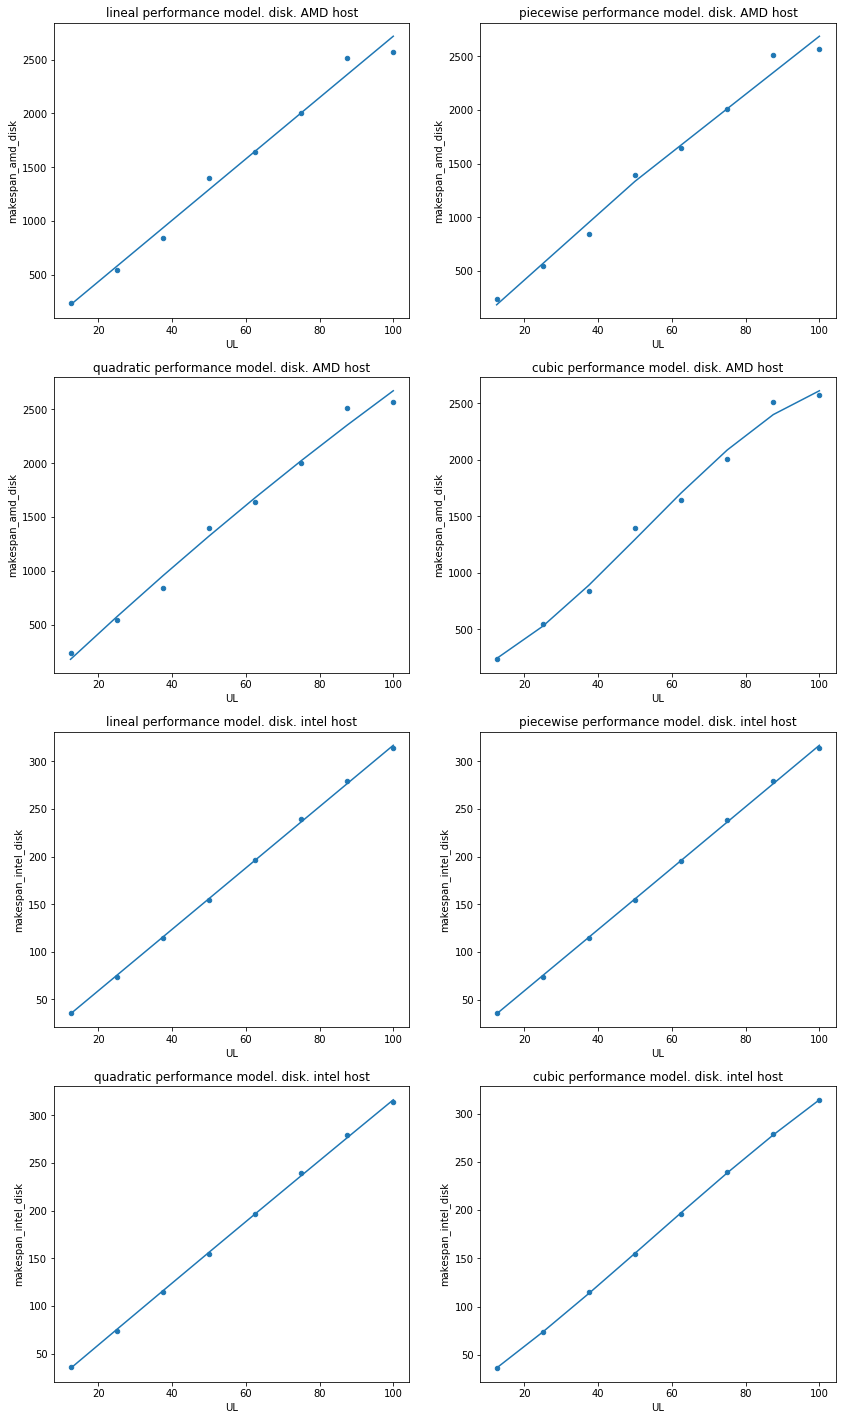

In [105]:
f, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(4, 2, sharey=False, figsize=(14, 25))
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_disk', ax=ax1)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_disk', ax=ax2)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_disk', ax=ax3)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_amd_disk', ax=ax4)

df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_disk', ax=ax5)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_disk', ax=ax6)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_disk', ax=ax7)
df_exe_performance_single.plot(kind='scatter', x='UL', y='makespan_intel_disk', ax=ax8)


#AMD
ax1.plot(df_exe_performance_single.UL, linear_model_performance_amd_disk.predict())
ax1.set_title('lineal performance model. disk. AMD host')

ax2.plot(df_exe_performance_single.UL, piecewise_model_performance_amd_disk.predict())
ax2.set_title('piecewise performance model. disk. AMD host')

ax3.plot(df_exe_performance_single.UL, quadratic_model_performance_amd_disk.predict())
ax3.set_title('quadratic performance model. disk. AMD host')

ax4.plot(df_exe_performance_single.UL, cubic_model_performance_amd_disk.predict())
ax4.set_title('cubic performance model. disk. AMD host')

#INTEL
ax5.plot(df_exe_performance_single.UL, linear_model_performance_intel_disk.predict())
ax5.set_title('lineal performance model. disk. intel host')

ax6.plot(df_exe_performance_single.UL, piecewise_model_performance_intel_disk.predict())
ax6.set_title('piecewise performance model. disk. intel host')

ax7.plot(df_exe_performance_single.UL, quadratic_model_performance_intel_disk.predict())
ax7.set_title('quadratic performance model. disk. intel host')

ax8.plot(df_exe_performance_single.UL, cubic_model_performance_intel_disk.predict())
ax8.set_title('cubic performance model. disk. intel host')





printing params cpu-bound workload performance models

In [106]:


print ('******************* AMD linear performance model - cpu bound workload - params *******************')
display (linear_model_performance_amd_cpu.params)
print (' ')
print ('******************* Intel linear performance model - cpu bound workload - params *******************')
display (linear_model_performance_intel_cpu.params)
print (' ')

print ('******************* AMD piecewise performance model - cpu bound workload - params *******************')
display (piecewise_model_performance_amd_cpu.params)
print (' ')
print ('******************* Intel piecewise performance model - cpu bound workload - params *******************')
display (piecewise_model_performance_intel_cpu.params)
print (' ')

print ('******************* AMD quadratic performance model - cpu bound workload - params *******************')
display (quadratic_model_performance_amd_cpu.params)
print (' ')
print ('******************* Intel quadratic performance model - cpu bound workload - params *******************')
display (quadratic_model_performance_intel_cpu.params)
print (' ')
print ('******************* AMD cubic performance model - cpu bound workload - params ***********************')
display (cubic_model_performance_amd_cpu.params)
print (' ')
print ('******************* Intel cubic performance model - cpu bound workload - params ***********************')
display (cubic_model_performance_intel_cpu.params)



******************* AMD linear performance model - cpu bound workload - params *******************


Intercept    43.23792517
UL            0.04183900
dtype: float64

 
******************* Intel linear performance model - cpu bound workload - params *******************


Intercept    30.02500000
UL            0.07466667
dtype: float64

 
******************* AMD piecewise performance model - cpu bound workload - params *******************


Intercept    44.93257576
UL           -0.01464935
UL2           0.09490043
dtype: float64

 
******************* Intel piecewise performance model - cpu bound workload - params *******************


Intercept    38.13409091
UL           -0.19563636
UL2           0.45410909
dtype: float64

 
******************* AMD quadratic performance model - cpu bound workload - params *******************


Intercept          46.27130102
UL                 -0.10376304
np.power(UL, 2)     0.00129424
dtype: float64

 
******************* Intel quadratic performance model - cpu bound workload - params *******************


Intercept          43.13214286
UL                 -0.55447619
np.power(UL, 2)     0.00559238
dtype: float64

 
******************* AMD cubic performance model - cpu bound workload - params ***********************


Intercept          40.95850340
UL                  0.33843345
np.power(UL, 2)    -0.00797901
np.power(UL, 3)     0.00005495
dtype: float64

 
******************* Intel cubic performance model - cpu bound workload - params ***********************


Intercept          29.20714286
UL                  0.60453391
np.power(UL, 2)    -0.01871307
np.power(UL, 3)     0.00014403
dtype: float64

printing params mem-bound workload performance models

In [107]:


print ('******************* AMD linear performance model - mem bound workload - params *******************')
display (linear_model_performance_amd_mem.params)
print (' ')
print ('******************* Intel linear performance model - mem bound workload - params *******************')
display (linear_model_performance_intel_mem.params)
print (' ')

print ('******************* AMD piecewise performance model - mem bound workload - params *******************')
display (piecewise_model_performance_amd_mem.params)
print (' ')
print ('******************* Intel piecewise performance model - mem bound workload - params *******************')
display (piecewise_model_performance_intel_mem.params)
print (' ')

print ('******************* AMD quadratic performance model - mem bound workload - params *******************')
display (quadratic_model_performance_amd_mem.params)
print (' ')
print ('******************* Intel quadratic performance model - mem bound workload - params *******************')
display (quadratic_model_performance_intel_mem.params)
print (' ')
print ('******************* AMD cubic performance model - mem bound workload - params ***********************')
display (cubic_model_performance_amd_mem.params)
print (' ')
print ('******************* Intel cubic performance model - mem bound workload - params ***********************')
display (cubic_model_performance_intel_mem.params)



******************* AMD linear performance model - mem bound workload - params *******************


Intercept    15.46250000
UL            4.41866667
dtype: float64

 
******************* Intel linear performance model - mem bound workload - params *******************


Intercept    18.25714286
UL            0.63242857
dtype: float64

 
******************* AMD piecewise performance model - mem bound workload - params *******************


Intercept    58.4125
UL            2.9870
UL2           2.4052
dtype: float64

 
******************* Intel piecewise performance model - mem bound workload - params *******************


Intercept    23.38636364
UL            0.46145455
UL2           0.28723636
dtype: float64

 
******************* AMD quadratic performance model - mem bound workload - params *******************


Intercept          77.27500000
UL                  1.45166667
np.power(UL, 2)     0.02637333
dtype: float64

 
******************* Intel quadratic performance model - mem bound workload - params *******************


Intercept          24.04732143
UL                  0.35450000
np.power(UL, 2)     0.00247048
dtype: float64

 
******************* AMD cubic performance model - mem bound workload - params ***********************


Intercept          39.50000000
UL                  4.59576768
np.power(UL, 2)    -0.03956121
np.power(UL, 3)     0.00039072
dtype: float64

 
******************* Intel cubic performance model - mem bound workload - params ***********************


Intercept          40.20357143
UL                 -0.99022222
np.power(UL, 2)     0.03067048
np.power(UL, 3)    -0.00016711
dtype: float64

linear_model_performance_amd_diskprinting params disk-bound workload performance models

In [108]:


print ('******************* AMD linear performance model - disk bound workload - params *******************')
display (linear_model_performance_amd_disk.params)
print (' ')
print ('******************* Intel linear performance model - disk bound workload - params *******************')
display (linear_model_performance_intel_disk.params)
print (' ')

print ('******************* AMD piecewise performance model - disk bound workload - params *******************')
display (piecewise_model_performance_amd_disk.params)
print (' ')
print ('******************* Intel piecewise performance model - disk bound workload - params *******************')
display (piecewise_model_performance_intel_disk.params)
print (' ')

print ('******************* AMD quadratic performance model - disk bound workload - params *******************')
display (quadratic_model_performance_amd_disk.params)
print (' ')
print ('******************* Intel quadratic performance model - disk bound workload - params *******************')
display (quadratic_model_performance_intel_disk.params)
print (' ')
print ('******************* AMD cubic performance model - disk bound workload - params ***********************')
display (cubic_model_performance_amd_disk.params)
print (' ')
print ('******************* Intel cubic performance model - disk bound workload - params ***********************')
display (cubic_model_performance_intel_disk.params)



******************* AMD linear performance model - disk bound workload - params *******************


Intercept   -134.42261905
UL            28.51536508
dtype: float64

 
******************* Intel linear performance model - disk bound workload - params *******************


Intercept   -5.32857143
UL           3.22095238
dtype: float64

 
******************* AMD piecewise performance model - disk bound workload - params *******************


Intercept   -199.32348485
UL            30.67872727
UL2           -3.63444848
dtype: float64

 
******************* Intel piecewise performance model - disk bound workload - params *******************


Intercept   -5.16363636
UL           3.21545455
UL2          0.00923636
dtype: float64

 
******************* AMD quadratic performance model - disk bound workload - params *******************


Intercept         -227.32142857
UL                  32.97450794
np.power(UL, 2)     -0.03963683
dtype: float64

 
******************* Intel quadratic performance model - disk bound workload - params *******************


Intercept         -6.42678571
UL                 3.27366667
np.power(UL, 2)   -0.00046857
dtype: float64

 
******************* AMD cubic performance model - disk bound workload - params ***********************


Intercept          70.88690476
UL                  8.15393555
np.power(UL, 2)     0.48087227
np.power(UL, 3)    -0.00308450
dtype: float64

 
******************* Intel cubic performance model - disk bound workload - params ***********************


Intercept          3.08571429
UL                 2.48191919
np.power(UL, 2)    0.01613506
np.power(UL, 3)   -0.00009839
dtype: float64

Rsquared and Rsquared Adj. metrics for performace models. Best models regarding rsquared are highlighted

In [109]:
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]


print ('******************* performance model - CPU bound workload - rsquared *******************')
performance_model_CPU_bound_workload_rsquared = pd.DataFrame(
[
    ['x',linear_model_performance_amd_disk.rsquared,linear_model_performance_amd_disk.rsquared_adj
     ,linear_model_performance_intel_disk.rsquared,linear_model_performance_intel_disk.rsquared_adj],
    ['x + xaux',piecewise_model_performance_amd_cpu.rsquared,piecewise_model_performance_amd_cpu.rsquared_adj,
     piecewise_model_performance_intel_cpu.rsquared,piecewise_model_performance_intel_cpu.rsquared_adj],
    ['x^2',quadratic_model_performance_amd_cpu.rsquared,quadratic_model_performance_amd_cpu.rsquared_adj,
     quadratic_model_performance_intel_cpu.rsquared,quadratic_model_performance_intel_cpu.rsquared_adj],
    ['x^3',cubic_model_performance_amd_cpu.rsquared,cubic_model_performance_amd_cpu.rsquared_adj,
     cubic_model_performance_intel_cpu.rsquared,cubic_model_performance_intel_cpu.rsquared_adj],
 
]
)

pd.set_option('precision', 5)
performance_model_CPU_bound_workload_rsquared.columns=['MODEL','AMDR2','AMDR2_ADJ','INTELR2','INTELR2_ADJ']
display(performance_model_CPU_bound_workload_rsquared.style.apply(highlight_max, subset=['AMDR2','AMDR2_ADJ','INTELR2','INTELR2_ADJ']))
print (' ')


print ('******************* performance model - mem bound workload - rsquared *******************')
performance_model_mem_bound_workload_rsquared = pd.DataFrame(
[
    ['x',linear_model_performance_amd_disk.rsquared,linear_model_performance_amd_disk.rsquared_adj,
     linear_model_performance_intel_disk.rsquared,linear_model_performance_intel_disk.rsquared_adj,],
    ['x + xaux',piecewise_model_performance_amd_mem.rsquared,piecewise_model_performance_amd_mem.rsquared_adj,
     piecewise_model_performance_intel_mem.rsquared,piecewise_model_performance_intel_mem.rsquared_adj],
    ['x^2',quadratic_model_performance_amd_mem.rsquared,quadratic_model_performance_amd_mem.rsquared_adj,
     quadratic_model_performance_intel_mem.rsquared,quadratic_model_performance_intel_mem.rsquared_adj],
    ['x^3',cubic_model_performance_amd_mem.rsquared,cubic_model_performance_amd_mem.rsquared_adj,
     cubic_model_performance_intel_mem.rsquared, cubic_model_performance_intel_mem.rsquared_adj],
 
]
)

pd.set_option('precision', 5)
performance_model_mem_bound_workload_rsquared.columns=['MODEL','AMDR2','AMDR2_ADJ','INTELR2','INTELR2_ADJ']
display(performance_model_mem_bound_workload_rsquared.style.apply(highlight_max, subset=['AMDR2','AMDR2_ADJ','INTELR2','INTELR2_ADJ']))
print (' ')

print ('******************* performance model - disk bound workload - rsquared *******************')
performance_model_disk_bound_workload_rsquared = pd.DataFrame(
[
    ['x',linear_model_performance_amd_disk.rsquared,linear_model_performance_amd_disk.rsquared,
     linear_model_performance_intel_disk.rsquared, linear_model_performance_intel_disk.rsquared
    ],
    ['x + xaux',piecewise_model_performance_amd_disk.rsquared,piecewise_model_performance_amd_disk.rsquared,
     piecewise_model_performance_intel_disk.rsquared,piecewise_model_performance_intel_disk.rsquared
    ],
    ['x^2',quadratic_model_performance_amd_disk.rsquared,quadratic_model_performance_amd_disk.rsquared,
     quadratic_model_performance_intel_disk.rsquared,quadratic_model_performance_intel_disk.rsquared
    ],
    ['x^3',cubic_model_performance_amd_disk.rsquared,cubic_model_performance_amd_disk.rsquared,
     cubic_model_performance_intel_disk.rsquared, cubic_model_performance_intel_disk.rsquared
    ],
 
]
)

pd.set_option('precision', 5)
performance_model_disk_bound_workload_rsquared.columns=['MODEL','AMDR2','AMDR2_ADJ','INTELR2','INTELR2_ADJ']
display(performance_model_disk_bound_workload_rsquared.style.apply(highlight_max, subset=['AMDR2','AMDR2_ADJ','INTELR2','INTELR2_ADJ']))
print (' ')

#cubic_model_performance_amd_disk.summary()

#dir(cubic_model_performance_amd_disk)



******************* performance model - CPU bound workload - rsquared *******************


,MODEL,AMDR2,AMDR2_ADJ,INTELR2,INTELR2_ADJ
0,x,0.98768,0.98562,0.99958,0.99951
1,x + xaux,0.53887,0.35441,0.48883,0.28436
2,x^2,0.65197,0.51276,0.66616,0.53263
3,x^3,0.89498,0.81622,0.85611,0.74819


 
******************* performance model - mem bound workload - rsquared *******************


,MODEL,AMDR2,AMDR2_ADJ,INTELR2,INTELR2_ADJ
0,x,0.98768,0.98562,0.99958,0.99951
1,x + xaux,0.99248,0.98947,0.90836,0.8717
2,x^2,0.99617,0.99464,0.90538,0.86753
3,x^3,0.9988,0.9979,0.927,0.87224


 
******************* performance model - disk bound workload - rsquared *******************


,MODEL,AMDR2,AMDR2_ADJ,INTELR2,INTELR2_ADJ
0,x,0.98768,0.98768,0.99958,0.99958
1,x + xaux,0.98868,0.98868,0.99958,0.99958
2,x^2,0.98887,0.98887,0.9996,0.9996
3,x^3,0.99286,0.99286,0.99992,0.99992


### 6 Conclusion and Future Work

This notebook presented detailed python scripts for proccesing output files of power characterization experiments. It allows to expose the scientific method in a clear manner and minimize errors in calculations. Also, the processing is completely reproducible from raw data. The work shows different analysis of the data, comparing combined and single scenarios, taking advantage of pandas dataframe potential. Finally, different power consumption models are presented and implemented using linear regression. The python models are implemented easily and without errors. Several error tests over the models are provided by the framework. In the future more complex models (that consider the dependency of the combined execution) are going to be implemented. 


## 7 References


- [The publication related to this work](https://link.springer.com/chapter/10.1007/978-3-319-73353-1_2).
- [Piecewise model explanation](http://songhuiming.github.io/pages/2015/09/22/piecewise-linear-function-and-the-explanation/). Accessed: Jan 29, 2018
- [R-squared metric](https://en.wikipedia.org/wiki/Coefficient_of_determination). Accessed: Jan 20, 2018


## Extra

#### STATISICTICS TEST

Example of statistics test applied over AMD data, simple executions

In [39]:
def printStatisticTests(experiments):
    shapiro_results =  experiments.apply(lambda x:scipy.stats.shapiro(x),axis = 0) 
    ks_results =  experiments.apply(lambda x:scipy.stats.kstest(x,cdf='norm'),axis = 0) 
    anderson_results =  experiments.apply(lambda x:scipy.stats.anderson(x),axis = 0) 
    dagostino_results =  experiments.apply(lambda x:scipy.stats.mstats.normaltest(x),axis = 0) 
    tests=pd.concat([shapiro_results,
                    ks_results,
                     anderson_results,
                     dagostino_results
                    ]
                    
                    ,axis=1)
    tests.columns = ['Shapiro-Wilk',
                       'Kolmogorov-Smirnov',
                       'Anderson-Darling',
                       'D’Agostino and Pearson',
                      ]
    display(tests)

#AMD CPU
experiments = pd.DataFrame()
experiments = pd.concat(
    [
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l12y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l25']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l37y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l50']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l62y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l75']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l87y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l100']['power_average'].reset_index()
    ],axis=1)  
experiments = experiments.drop(['index'], axis=1)
#display(experiments)
experiments.columns = ['c1l12y5',
                       'c1l25',
                       'c1l37y5',
                       'c1l50',
                       'c1l62y5',
                       'c1l75',
                       'c1l87y5',
                       'c1l100',
                      ]

printStatisticTests(experiments)

#AMD MEM
experiments = pd.DataFrame()
experiments = pd.concat(
    [
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l12y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l25']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l37y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l50']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l62y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l75']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l87y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='m2l100']['power_average'].reset_index()
    ],axis=1)  
experiments = experiments.drop(['index'], axis=1)
#display(experiments)
experiments.columns = ['m2l12y5',
                       'm2l25',
                       'm2l37y5',
                       'm2l50',
                       'm2l62y5',
                       'm2l75',
                       'm2l87y5',
                       'm2l100',
                      ]

printStatisticTests(experiments)

#AMD DISK
experiments = pd.DataFrame()
experiments = pd.concat(
    [
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l12y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l25']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l37y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l50']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l62y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l75']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l87y5']['power_average'].reset_index(),
df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='f1l100']['power_average'].reset_index()
    ],axis=1)  
experiments = experiments.drop(['index'], axis=1)
#display(experiments)
experiments.columns = ['f1l12y5',
                       'f1l25',
                       'f1l37y5',
                       'f1l50',
                       'f1l62y5',
                       'f1l75',
                       'f1l87y5',
                       'f1l100',
                      ]

printStatisticTests(experiments)

               

,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling,D’Agostino and Pearson
c1l12y5,"(0.9549569487571716, 0.4486144483089447)","(1.0, 0.0)","(0.336068416326, [0.506, 0.577, 0.692, 0.807, ...","(2.163589252, 0.338986625222)"
c1l25,"(0.9188036918640137, 0.09397034347057343)","(1.0, 0.0)","(0.551213851257, [0.506, 0.577, 0.692, 0.807, ...","(9.45892698654, 0.00883120777135)"
c1l37y5,"(0.9544210433959961, 0.43919917941093445)","(1.0, 0.0)","(0.351096848699, [0.506, 0.577, 0.692, 0.807, ...","(2.35349265541, 0.308280151171)"
c1l50,"(0.9634792804718018, 0.6154409646987915)","(1.0, 0.0)","(0.239354851191, [0.506, 0.577, 0.692, 0.807, ...","(1.2670861136, 0.530708136939)"
c1l62y5,"(0.9514138698577881, 0.3890632092952728)","(1.0, 0.0)","(0.336690917367, [0.506, 0.577, 0.692, 0.807, ...","(3.30885103829, 0.191201865972)"
c1l75,"(0.9672264456748962, 0.6955713629722595)","(1.0, 0.0)","(0.278160844387, [0.506, 0.577, 0.692, 0.807, ...","(0.446240530965, 0.800018628882)"
c1l87y5,"(0.9631222486495972, 0.6079285144805908)","(1.0, 0.0)","(0.355614287705, [0.506, 0.577, 0.692, 0.807, ...","(0.971424236616, 0.615258903595)"
c1l100,"(0.9239330887794495, 0.1179724931716919)","(1.0, 0.0)","(0.562857381786, [0.506, 0.577, 0.692, 0.807, ...","(2.97724884578, 0.22568288633)"


,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling,D’Agostino and Pearson
m2l12y5,"(0.7332601547241211, 0.00010211214976152405)","(1.0, 0.0)","(1.51560001625, [0.506, 0.577, 0.692, 0.807, 0...","(29.8944266951, 3.2248366681e-07)"
m2l25,"(0.9519350528717041, 0.39742133021354675)","(1.0, 0.0)","(0.268786334182, [0.506, 0.577, 0.692, 0.807, ...","(1.21162917777, 0.545629781609)"
m2l37y5,"(0.898122251033783, 0.03803310915827751)","(1.0, 0.0)","(0.84813568789, [0.506, 0.577, 0.692, 0.807, 0...","(3.34025853489, 0.188222732995)"
m2l50,"(0.9187986254692078, 0.09394923597574234)","(1.0, 0.0)","(0.59802706514, [0.506, 0.577, 0.692, 0.807, 0...","(1.60445333882, 0.448329570131)"
m2l62y5,"(0.8155574798583984, 0.00148799701128155)","(1.0, 0.0)","(1.21736260688, [0.506, 0.577, 0.692, 0.807, 0...","(15.7316112282, 0.000383640126983)"
m2l75,"(0.8784505128860474, 0.016594799235463142)","(1.0, 0.0)","(1.00806199815, [0.506, 0.577, 0.692, 0.807, 0...","(3.17925406477, 0.204001683569)"
m2l87y5,"(0.9732213020324707, 0.8209081888198853)","(1.0, 0.0)","(0.208311106843, [0.506, 0.577, 0.692, 0.807, ...","(0.110477810241, 0.946259054814)"
m2l100,"(0.9886099100112915, 0.9958749413490295)","(1.0, 0.0)","(0.16155458214, [0.506, 0.577, 0.692, 0.807, 0...","(0.49013699713, 0.78265092594)"


,Shapiro-Wilk,Kolmogorov-Smirnov,Anderson-Darling,D’Agostino and Pearson
f1l12y5,"(0.9447104334831238, 0.29382824897766113)","(1.0, 0.0)","(0.54126223629, [0.506, 0.577, 0.692, 0.807, 0...","(0.812114734783, 0.666271944045)"
f1l25,"(0.9672889709472656, 0.6969166994094849)","(1.0, 0.0)","(0.256182649259, [0.506, 0.577, 0.692, 0.807, ...","(0.188234810747, 0.910175896426)"
f1l37y5,"(0.9216158986091614, 0.10644491761922836)","(1.0, 0.0)","(0.54617282619, [0.506, 0.577, 0.692, 0.807, 0...","(2.12162728553, 0.346174033714)"
f1l50,"(0.9366365075111389, 0.2069837898015976)","(1.0, 0.0)","(0.485990548784, [0.506, 0.577, 0.692, 0.807, ...","(3.32566788991, 0.189600899504)"
f1l62y5,"(0.8900244235992432, 0.02691994421184063)","(1.0, 0.0)","(0.804298122237, [0.506, 0.577, 0.692, 0.807, ...","(3.379638164, 0.184552909916)"
f1l75,"(0.959485650062561, 0.5336245894432068)","(1.0, 0.0)","(0.282828008567, [0.506, 0.577, 0.692, 0.807, ...","(0.608042853846, 0.737845056532)"
f1l87y5,"(0.6427513360977173, 8.443055776297115e-06)","(1.0, 0.0)","(2.75376526301, [0.506, 0.577, 0.692, 0.807, 0...","(22.7031585978, 1.17509167526e-05)"
f1l100,"(0.9321761131286621, 0.17003470659255981)","(1.0, 0.0)","(0.545846577546, [0.506, 0.577, 0.692, 0.807, ...","(2.5423061379, 0.280507990175)"


### energy deviation for simple execution


In [40]:
df_exe_energy_single_amd_c1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='c1']\
         .groupby(['UL']).std().reset_index()

df_exe_energy_single_amd_m2_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='m2']\
         .groupby('UL').std().reset_index()

df_exe_energy_single_amd_f1_pw = df_exe_energy_single_amd[df_exe_energy_single_amd['bkcod']=='f1']\
         .groupby('UL').std().reset_index()

df_exe_energy_single_intel_c1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='c1']\
         .groupby(['UL']).std().reset_index()
    
df_exe_energy_single_intel_m2_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='m2']\
         .groupby('UL').std().reset_index()

df_exe_energy_single_intel_f1_pw = df_exe_energy_single_intel[df_exe_energy_single_intel['bkcod']=='f1']\
         .groupby('UL').std().reset_index()    
   

df_result = pd.concat([df_exe_energy_single_amd_c1_pw,\
                    df_exe_energy_single_amd_m2_pw['power_average'],\
                    df_exe_energy_single_amd_f1_pw['power_average'],\
                    df_exe_energy_single_intel_c1_pw['power_average'],\
                    df_exe_energy_single_intel_m2_pw['power_average'],\
                    df_exe_energy_single_intel_f1_pw['power_average']],\
                  axis=1)    

df_result.columns = ['UL', 'AMD cpu', 'AMD memory','AMD disk', 'Intel cpu', 'Intel memory','Intel disk']
display (df_result,'Energy-simple-AMD')


,UL,AMD cpu,AMD memory,AMD disk,Intel cpu,Intel memory,Intel disk
0,12.5,0.543,1.791,0.353,1.663,6.430,0.934
1,25.0,0.665,1.114,0.466,2.018,4.818,0.564
2,37.5,0.480,1.910,0.564,2.115,4.766,0.558
3,50.0,0.795,2.681,0.265,2.904,6.837,0.749
4,62.5,1.575,6.356,0.310,2.745,3.874,0.743
5,75.0,1.402,5.914,0.416,1.791,5.437,0.754
6,87.5,0.972,5.591,1.559,2.250,3.971,0.617
7,100.0,1.839,2.982,0.592,4.305,9.332,0.961


'Energy-simple-AMD'

### deviation energy double execution

,ULx,ULy,AMD cpu mem,AMD cpu disk,AMD mem disk,Intel cpu mem,Intel cpu disk,Intel mem disk
0,25,25,2.7,1.1,1.5,2.0,2.3,8.3
1,25,50,1.6,1.3,5.5,2.9,1.9,5.9
2,25,75,3.3,1.2,2.0,2.1,3.2,7.6
3,50,25,2.2,2.6,9.1,2.1,2.6,6.0
4,50,50,2.6,4.9,12.9,4.2,2.8,4.2
5,75,25,6.6,3.5,4.0,2.6,2.9,5.0


'Energy-double'

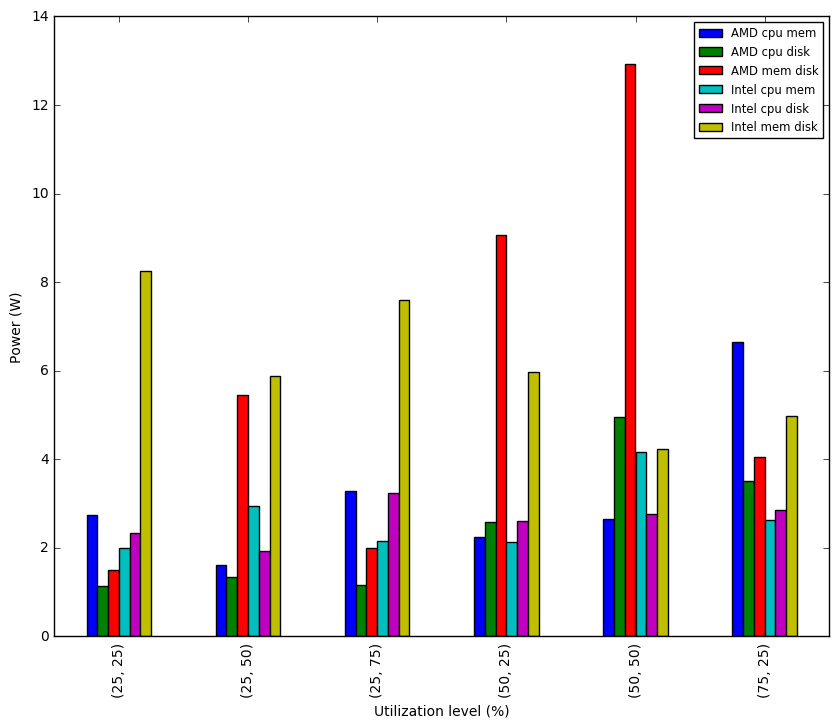

In [18]:
df_exe_energy_double_amd_pw_c1m2 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='c1m2']\
         .groupby(['ULx','ULy']).std().reset_index()
df_exe_energy_double_amd_pw_c1f1 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='c1f1']\
         .groupby(['ULx','ULy']).std().reset_index()
df_exe_energy_double_amd_pw_m2f1 = df_exe_energy_double_amd[df_exe_energy_double_amd['bkcod']=='m2f1']\
         .groupby(['ULx','ULy']).std().reset_index()    

df_exe_energy_double_intel_pw_c1m2 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1m2']\
         .groupby(['ULx','ULy']).std().reset_index()
df_exe_energy_double_intel_pw_c1f1 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='c1f1']\
         .groupby(['ULx','ULy']).std().reset_index()
df_exe_energy_double_intel_pw_m2f1 = df_exe_energy_double_intel[df_exe_energy_double_intel['bkcod']=='m2f1']\
         .groupby(['ULx','ULy']).std().reset_index()
   
df_result = pd.concat([\
                    df_exe_energy_double_amd_pw_c1m2,\
                       
                    df_exe_energy_double_amd_pw_c1f1['power_average'],\
                    df_exe_energy_double_amd_pw_m2f1['power_average'],\
                    
                       
                    df_exe_energy_double_intel_pw_c1m2['power_average'],\
                    df_exe_energy_double_intel_pw_c1f1['power_average'],\
                                           
                    df_exe_energy_double_intel_pw_m2f1['power_average'],\
                   ],axis=1)    
    

df_result.columns = ['ULx', 
                     'ULy', 
                    'AMD cpu mem',
                     'AMD cpu disk',
                     'AMD mem disk',
                     'Intel cpu mem',
                     'Intel cpu disk',
                     'Intel mem disk'
                    ]

display (df_result,'Energy-double')
aux = df_result.plot(x= ['ULx','ULy'],y=['AMD cpu mem', 'AMD cpu disk', 'AMD mem disk',\
                  'Intel cpu mem', 'Intel cpu disk', 'Intel mem disk'],kind='bar', figsize=(10, 8))


aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Power (W)")


### deviation triple

,UL,AMD cpu,AMD mem,AMD disk,Intel cpu,Intel mem,Intel disk
0,12.5,0.5,4.7,5.0,8.6,4.7,0.9
1,25.0,0.4,7.4,29.0,5.7,0.9,1.5
2,37.5,0.0,14.2,29.2,9.7,2.2,2.4
3,50.0,0.0,12.3,184.5,3.7,1.1,3.2
4,62.5,0.0,12.9,184.9,0.6,4.3,3.8
5,75.0,0.0,11.4,182.7,0.8,1.7,5.1
6,87.5,0.0,14.6,367.8,9.4,1.5,25.8
7,100.0,4.5,16.2,147.2,11.0,2.0,4.0


'Performance-single'

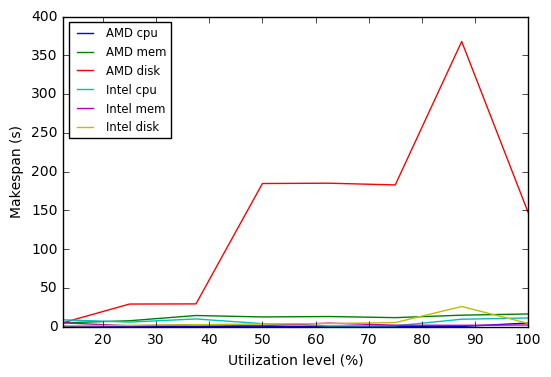

In [22]:
df_exe_performance_single_amd_pw_c1unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='c1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index()

df_exe_performance_single_amd_pw_m2unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='m2unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index()
    
df_exe_performance_single_amd_pw_f1unt = df_exe_performance_single_amd[df_exe_performance_single_amd['codu']=='f1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index() 
    
df_exe_performance_single_intel_pw_c1unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='c1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index()

df_exe_performance_single_intel_pw_m2unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='m2unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index()
    
df_exe_performance_single_intel_pw_f1unt = df_exe_performance_single_intel[df_exe_performance_single_intel['codu']=='f1unt']\
       .groupby(['UL','exe']).max().reset_index().groupby(['UL']).std().reset_index()
    
    
df_result = pd.concat([df_exe_performance_single_amd_pw_c1unt,\
                    df_exe_performance_single_amd_pw_m2unt['seconds'],\
                    df_exe_performance_single_amd_pw_f1unt['seconds'],\
                   df_exe_performance_single_intel_pw_c1unt['seconds'],\
                    df_exe_performance_single_intel_pw_m2unt['seconds'],\
                    df_exe_performance_single_intel_pw_f1unt['seconds']],\
                  axis=1)    


df_result.columns = ['UL', 'AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu', 'Intel mem', 'Intel disk']
display (df_result,'Performance-single')

aux=df_result.plot(x= ['UL'],y=['AMD cpu', 'AMD mem', 'AMD disk', 'Intel cpu',\
                                         'Intel mem', 'Intel disk'])

aux.set_xlabel("Utilization level (%)")
aux.set_ylabel("Makespan (s)")


In [56]:
### iqr calculation example

In [47]:
CPU100 = df_exe_energy_single_amd[df_exe_energy_single_amd['cod_x']=='c1l100']
iqr = CPU100["power_average"].quantile(0.75) - CPU100["power_average"].quantile(0.25)
display(iqr)

1.6908563134977612